In [4]:
%matplotlib inline

# Imports
import gc
import matplotlib.pyplot as plt
import os
import statsmodels.stats.proportion
import sklearn.pipeline

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from legacy_model import *

In [5]:
# Get raw data
raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")

# Get feature data
if os.path.exists("../data/output/feature_data.hdf.gz"):
    print("Loading from HDF5 cache")
    feature_df = pandas.read_hdf("../data/output/feature_data.hdf.gz", "root")
else:
    # Process
    feature_df = preprocess_raw_data(raw_data, include_direction=True)
    
    # Write out feature datas
    feature_df.to_hdf("../data/output/feature_data.hdf.gz", "root", complevel=6, complib="zlib")

Loading from HDF5 cache


In [6]:
# Downsample to float
feature_df = feature_df.astype(numpy.float16)

In [7]:
# Remove term
nonterm_features = [f for f in feature_df.columns if not f.startswith("term_")]
original_feature_df = feature_df.copy()
feature_df = original_feature_df.loc[:, nonterm_features].copy()
gc.collect()

823

In [8]:
# Output some diagnostics on features
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(249793, 64)
(249793, 1501)


In [22]:
# Reset output file timestamp per run
file_timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Reset seed per run
numpy.random.seed(0)

# Setup training time period
dummy_window = 10
min_training_years = 25
term_range = range(raw_data["term"].min() + min_training_years,
                   raw_data["term"].max())

# Setting growing random forest parameters
# Number of trees to grow per term
trees_per_term = 5

# Number of trees to begin with
initial_trees = min_training_years * trees_per_term

# Number of years between "forest fires"
reset_interval = 9999

# Setup model
m = None
term_count = 0
feature_importance_df = pandas.DataFrame()

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    dummy_train_index = ((raw_data.loc[:, "term"] < term) & (raw_data.loc[:, "term"] >= (term-dummy_window))).values
    test_index = (raw_data.loc[:, "term"] == term).values
    if test_index.sum() == 0:
        continue
    
    # Setup train data
    feature_data_train = feature_df.loc[train_index, :]
    target_data_train = (raw_data.loc[train_index, "justice_outcome_disposition"]).astype(int)
    target_data_weights = target_data_train.value_counts() / target_data_train.shape[0]

    # Setup test data
    feature_data_test = feature_df.loc[test_index, :]
    target_data_test = (raw_data.loc[test_index, "justice_outcome_disposition"]).astype(int)
        
    # Check if we should rebuild the model based on changing natural court
    if term_count % reset_interval == 0:
        # "Forest fire;" grow a new forest from scratch
        print("Reset interval hit; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        m = None
    else:
        # Check if the justice set has changed
        if set(raw_data.loc[raw_data.loc[:, "term"] == (term-1), "naturalCourt"].unique()) != \
            set(raw_data.loc[raw_data.loc[:, "term"] == (term), "naturalCourt"].unique()):
            # natural Court change; trigger forest fire
            print("Natural court change; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
            m = None
                                              
    # Build or grow a model depending on initial/reset condition
    if not m:
        # Grow an initial forest
        rf = sklearn.ensemble.RandomForestClassifier(n_estimators=initial_trees + (term_count * trees_per_term),
                                                     class_weight=target_data_weights.to_dict(),
                                                    warm_start=True,
                                                    n_jobs=-1)
        pipeline = sklearn.pipeline.Pipeline([("rf", rf)
                                             ])
        
        search_params = {"rf__min_samples_leaf": [1, 2]}
        m = sklearn.model_selection.GridSearchCV(pipeline, search_params, scoring='f1_weighted')
    else:
        # Grow the forest by increasing the number of trees (requires warm_start=True)
        m.set_params(estimator__rf__n_estimators=initial_trees + (term_count * trees_per_term))

    # Fit the forest model
    m.fit(feature_data_train,
          target_data_train)
    #print(m.get_params())
    
    # Record feature weights
    current_feature_importance_df = pandas.DataFrame(list(zip(feature_df.columns, m.best_estimator_.steps[-1][-1].feature_importances_)),
                                         columns=["feature", "importance"])
    current_feature_importance_df.loc[:, "term"] = term
    if feature_importance_df.shape[0] == 0:
        feature_importance_df = current_feature_importance_df.copy()
    else:
        feature_importance_df = feature_importance_df.append(current_feature_importance_df.copy())

    # Fit the "dummy" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_df.loc[dummy_train_index, :],
          (raw_data.loc[dummy_train_index, "justice_outcome_disposition"]).astype(int))
    
    # Perform forest predictions
    raw_data.loc[test_index, "rf_predicted"] = m.predict(feature_data_test)
    
    # Store scores per class
    scores = m.predict_proba(feature_data_test)
    raw_data.loc[test_index, "rf_predicted_score_other"] = scores[:, 0]
    raw_data.loc[test_index, "rf_predicted_score_affirm"] = scores[:, 1]
    raw_data.loc[test_index, "rf_predicted_score_reverse"] = scores[:, 2]
    
    # Store dummy predictions
    raw_data.loc[test_index, "dummy_predicted"] = d.predict(feature_data_test)
    
    #  Clear
    del feature_data_train
    del feature_data_test
    del target_data_train
    del target_data_test
    gc.collect()

Term: 1816
Term: 1817
Term: 1818
Term: 1819
Term: 1820
Term: 1821
Term: 1822
Term: 1823
Term: 1824
Natural court change; rebuilding with 170 trees
Term: 1825
Term: 1826
Term: 1827
Natural court change; rebuilding with 185 trees
Term: 1828
Term: 1829
Term: 1830
Natural court change; rebuilding with 200 trees
Term: 1831
Term: 1832
Term: 1833
Term: 1834
Term: 1835
Natural court change; rebuilding with 225 trees
Term: 1836
Term: 1837
Natural court change; rebuilding with 235 trees
Term: 1838
Natural court change; rebuilding with 240 trees
Term: 1839
Term: 1840
Term: 1841
Term: 1842
Natural court change; rebuilding with 260 trees
Term: 1843
Term: 1844
Term: 1845
Natural court change; rebuilding with 275 trees
Term: 1846
Natural court change; rebuilding with 280 trees
Term: 1847
Natural court change; rebuilding with 285 trees
Term: 1848
Term: 1849
Term: 1850
Natural court change; rebuilding with 300 trees
Term: 1851
Natural court change; rebuilding with 305 trees
Term: 1852
Term: 1853
Natura

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Term: 1875
Term: 1876
Term: 1877
Natural court change; rebuilding with 435 trees
Term: 1878
Natural court change; rebuilding with 440 trees
Term: 1879
Term: 1880
Natural court change; rebuilding with 450 trees
Term: 1881
Natural court change; rebuilding with 455 trees
Term: 1882
Natural court change; rebuilding with 460 trees
Term: 1883
Term: 1884
Term: 1885
Term: 1886
Term: 1887
Natural court change; rebuilding with 485 trees
Term: 1888
Natural court change; rebuilding with 490 trees
Term: 1889
Natural court change; rebuilding with 495 trees
Term: 1890
Natural court change; rebuilding with 500 trees
Term: 1891
Natural court change; rebuilding with 505 trees
Term: 1892
Natural court change; rebuilding with 510 trees
Term: 1893
Natural court change; rebuilding with 515 trees
Term: 1894
Natural court change; rebuilding with 520 trees
Term: 1895
Natural court change; rebuilding with 525 trees
Term: 1896
Natural court change; rebuilding with 530 trees
Term: 1897
Natural court change; rebui

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Term: 1905
Term: 1906
Natural court change; rebuilding with 580 trees
Term: 1907
Natural court change; rebuilding with 585 trees
Term: 1908
Term: 1909
Natural court change; rebuilding with 595 trees
Term: 1910
Natural court change; rebuilding with 600 trees
Term: 1911
Natural court change; rebuilding with 605 trees
Term: 1912
Natural court change; rebuilding with 610 trees
Term: 1913
Term: 1914
Natural court change; rebuilding with 620 trees
Term: 1915
Natural court change; rebuilding with 625 trees
Term: 1916
Natural court change; rebuilding with 630 trees
Term: 1917
Term: 1918
Term: 1919
Term: 1920
Term: 1921
Natural court change; rebuilding with 655 trees
Term: 1922
Natural court change; rebuilding with 660 trees
Term: 1923
Natural court change; rebuilding with 665 trees
Term: 1924
Natural court change; rebuilding with 670 trees
Term: 1925
Natural court change; rebuilding with 675 trees
Term: 1926
Term: 1927
Term: 1928
Term: 1929
Natural court change; rebuilding with 695 trees
Term:

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Term: 1948
Term: 1949
Natural court change; rebuilding with 795 trees
Term: 1950
Term: 1951
Term: 1952
Term: 1953
Natural court change; rebuilding with 815 trees
Term: 1954
Natural court change; rebuilding with 820 trees
Term: 1955
Natural court change; rebuilding with 825 trees
Term: 1956
Natural court change; rebuilding with 830 trees
Term: 1957
Natural court change; rebuilding with 835 trees
Term: 1958
Natural court change; rebuilding with 840 trees
Term: 1959
Natural court change; rebuilding with 845 trees
Term: 1960
Term: 1961
Natural court change; rebuilding with 855 trees
Term: 1962
Natural court change; rebuilding with 860 trees
Term: 1963
Term: 1964
Term: 1965
Natural court change; rebuilding with 875 trees
Term: 1966
Term: 1967
Natural court change; rebuilding with 885 trees
Term: 1968
Natural court change; rebuilding with 890 trees
Term: 1969
Natural court change; rebuilding with 895 trees
Term: 1970
Natural court change; rebuilding with 900 trees
Term: 1971
Natural court ch

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Term: 2001
Term: 2002
Term: 2003
Term: 2004
Term: 2005
Natural court change; rebuilding with 1075 trees
Term: 2006
Natural court change; rebuilding with 1080 trees
Term: 2007
Term: 2008
Term: 2009
Natural court change; rebuilding with 1095 trees
Term: 2010
Natural court change; rebuilding with 1100 trees
Term: 2011
Term: 2012
Term: 2013


In [208]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"].astype(int)
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Setup reverse testing
reverse_target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"] > 0).astype(int)
reverse_target_predicted = (raw_data.loc[evaluation_index, "rf_predicted"] > 0).astype(int)
reverse_target_dummy = (raw_data.loc[evaluation_index, "dummy_predicted"] > 0).astype(int)
raw_data.loc[:, "rf_reverse_correct"] = numpy.nan
raw_data.loc[:, "dummy_reverse_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_reverse_correct"] = (reverse_target_actual == reverse_target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_reverse_correct"] = (reverse_target_actual == reverse_target_dummy).astype(float)

In [209]:
# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       0.82      0.60      0.69     39521
          0       0.61      0.78      0.69    113454
          1       0.64      0.50      0.56     93161

avg / total       0.65      0.64      0.64    246136

[[23588 11344  4589]
 [ 3151 88443 21860]
 [ 1856 44984 46321]]
0.643351642994

Dummy model
             precision    recall  f1-score   support

         -1       0.33      0.01      0.02     39521
          0       0.52      0.77      0.62    113454
          1       0.57      0.46      0.51     93161

avg / total       0.50      0.53      0.48    246136

[[  495 31931  7095]
 [  618 87102 25734]
 [  398 49888 42875]]
0.530080930867



In [272]:
# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(reverse_target_actual, reverse_target_predicted))
print(sklearn.metrics.confusion_matrix(reverse_target_actual, reverse_target_predicted))
print(sklearn.metrics.accuracy_score(reverse_target_actual, reverse_target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(reverse_target_actual, reverse_target_dummy))
print(sklearn.metrics.confusion_matrix(reverse_target_actual, reverse_target_dummy))
print(sklearn.metrics.accuracy_score(reverse_target_actual, reverse_target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

          0       0.73      0.83      0.78    152975
          1       0.64      0.50      0.56     93161

avg / total       0.69      0.70      0.69    246136

[[126526  26449]
 [ 46840  46321]]
0.702241850034

Dummy model
             precision    recall  f1-score   support

          0       0.70      0.79      0.74    152975
          1       0.57      0.46      0.51     93161

avg / total       0.65      0.66      0.65    246136

[[120146  32829]
 [ 50286  42875]]
0.66232083076



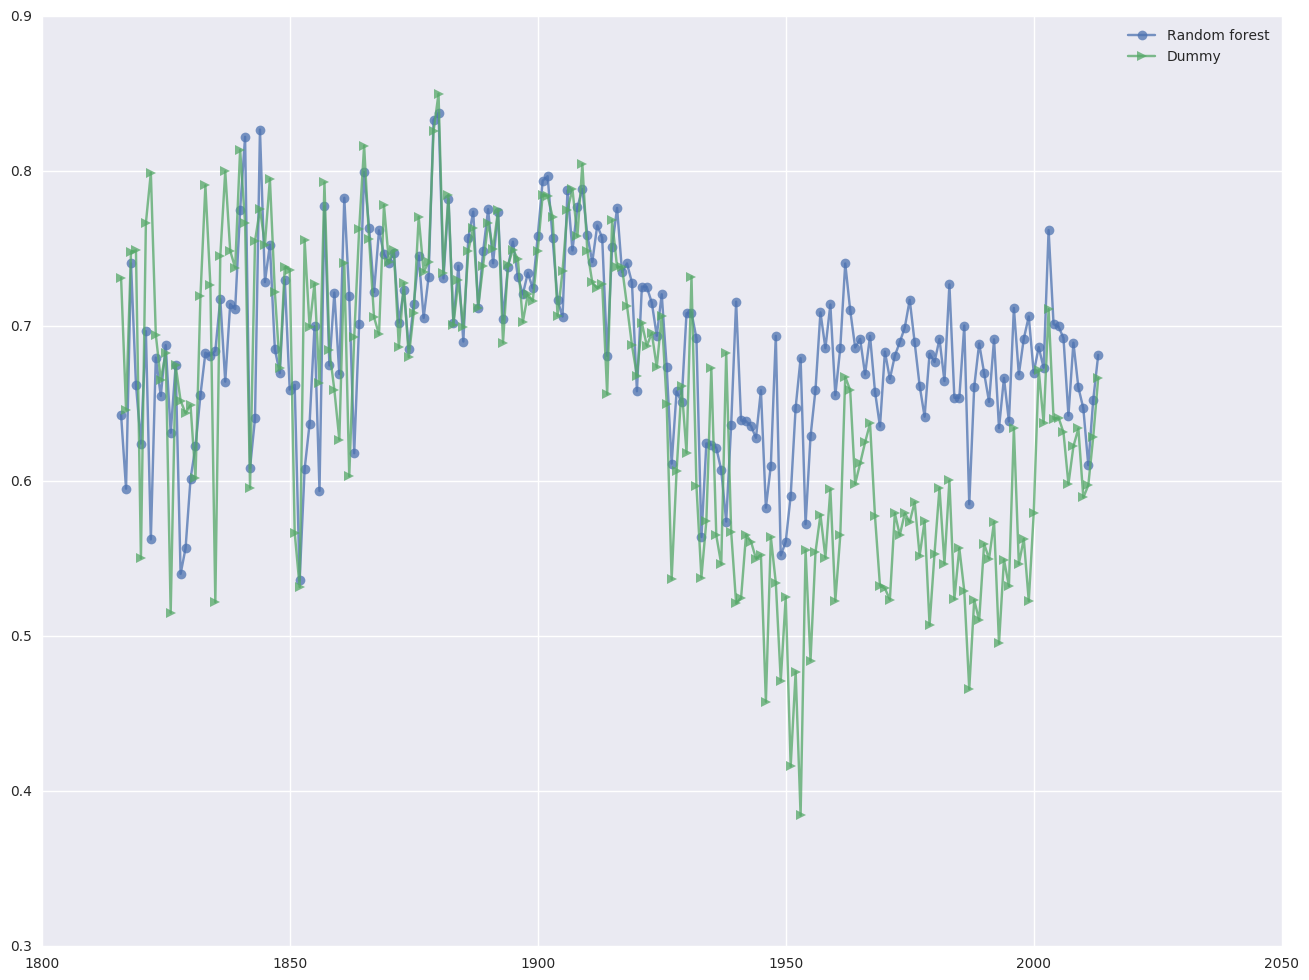

In [211]:
# Setup time series
rf_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct"].mean()
dummy_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct"].mean()
rf_reverse_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_reverse_correct"].mean()
dummy_reverse_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_reverse_correct"].mean()


# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_reverse_correct_ts.index, rf_reverse_correct_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_reverse_correct_ts.index, dummy_reverse_correct_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

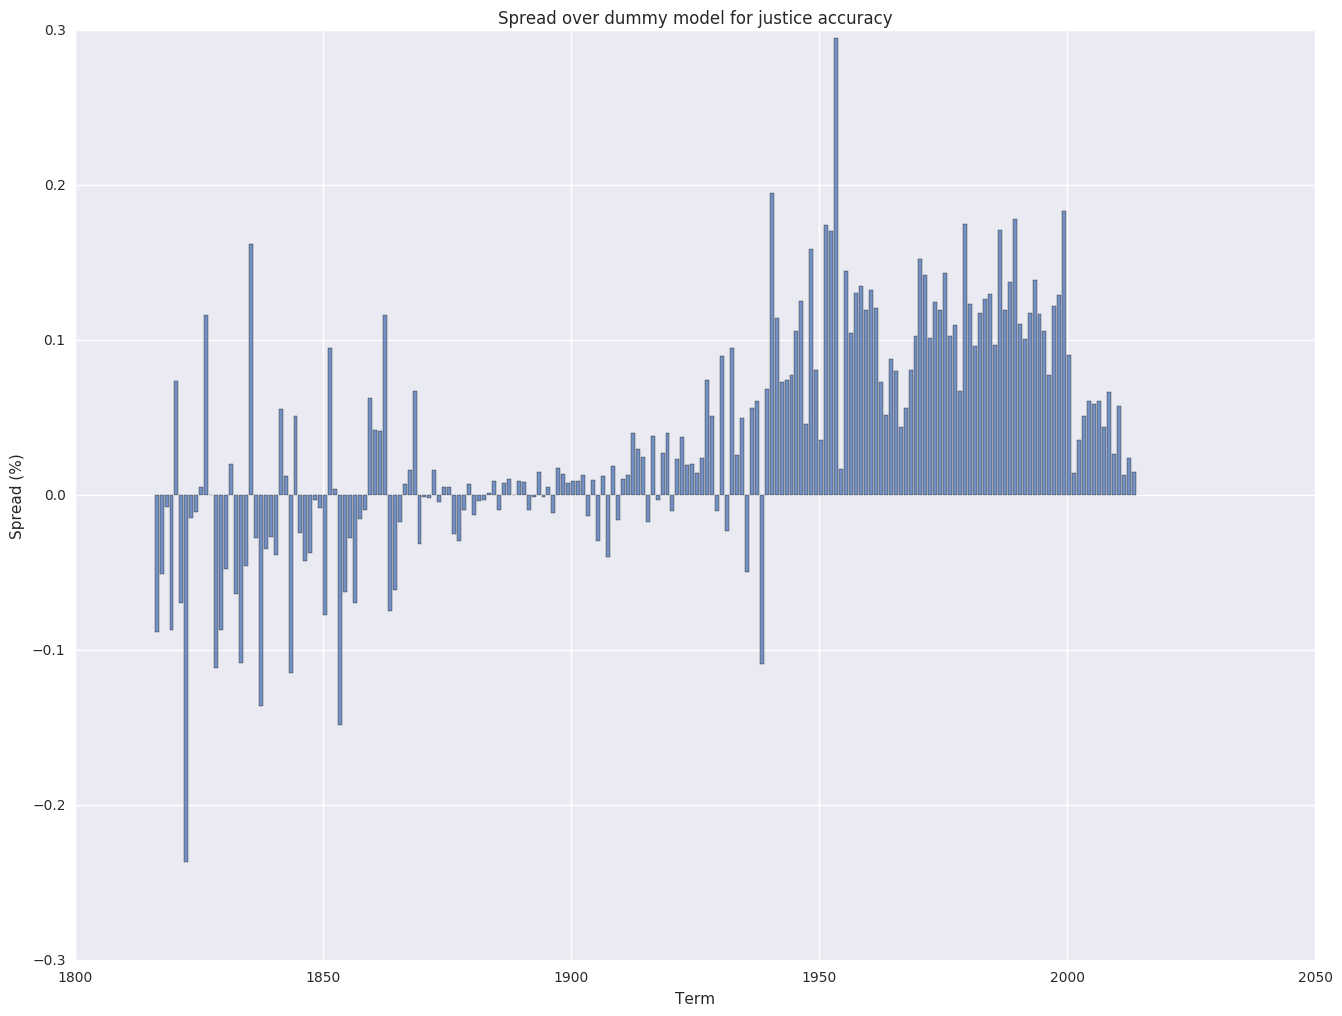

In [212]:
# Setup time series
rf_spread_ts = rf_reverse_correct_ts - dummy_reverse_correct_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_ts.index, rf_spread_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for justice accuracy")

In [213]:
# Feature importance
last_feature_importance_df = pandas.DataFrame(list(zip(feature_df.columns, m.best_estimator_.steps[-1][-1].feature_importances_)),
                                         columns=["feature", "importance"])
last_feature_importance_df.sort_values(["importance"], ascending=False).head(10)

,feature,importance
1499,justice_previous_lc_direction_diff,0.032234
1500,justice_cumulative_lc_direction_diff,0.029984
131,decision_delay,0.025791
1495,justice_previous_court_agreement,0.021564
1489,justice_previous_court_action,0.021123
1496,justice_cumulative_court_agreement,0.020638
0,natural_court_raw,0.020177
1490,justice_cumulative_court_action,0.019905
1487,justice_previous_action,0.018081
1483,justice_previous_court_direction,0.017163


In [214]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_correct"].sum(),
                                              raw_data.loc[evaluation_index, "rf_correct"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_correct"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=22.889503723571675, pvalue=2.1141649323309822e-57)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=12.922148099780216, pvalue=3.3758330558843768e-38)
Binomial:
0.0


In [215]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_reverse_correct_ts.values,
                   dummy_reverse_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_reverse_correct_ts.values,
                   dummy_reverse_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_reverse_correct"].sum(),
                                              raw_data.loc[evaluation_index, "rf_reverse_correct"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_reverse_correct"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=6.8571181388563485, pvalue=8.8414521527645033e-11)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=3.207158355209951, pvalue=0.0013405318238218979)
Binomial:
0.0


In [216]:
# Get outcomes as reverse/not-reverse for real data
raw_data.loc[:, "justice_outcome_reverse"] = (raw_data.loc[:, "justice_outcome_disposition"] > 0).astype(int)
raw_data.loc[:, "case_outcome_reverse"] = (raw_data.loc[:, "case_outcome_disposition"] > 0).astype(int)

In [217]:
# Get case-level prediction
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
raw_data.loc[evaluation_index, "rf_predicted_case"] = (raw_data.loc[evaluation_index, "rf_predicted"] > 0).astype(int)
raw_data.loc[evaluation_index, "dummy_predicted_case"] = (raw_data.loc[evaluation_index, "dummy_predicted"] > 0).astype(int)

rf_predicted_case = (raw_data.loc[evaluation_index, :]\
    .groupby("docketId")["rf_predicted_case"].mean() > 0.5).astype(int)

dummy_predicted_case = (raw_data.loc[evaluation_index, :]\
    .groupby("docketId")["dummy_predicted_case"].mean() > 0.5).astype(int)

actual_case = (raw_data.loc[evaluation_index, :]\
    .groupby("docketId")["case_outcome_reverse"].mean() > 0.5).astype(int)

In [218]:
# Output comparison
# Evaluation range
evaluation_index = case_data.loc[:, "term"].isin(term_range)
target_actual = case_data.loc[:, "case_outcome_reverse"]
target_predicted = case_data.loc[:, "rf_predicted_case"]
target_dummy = case_data.loc[:, "dummy_predicted_case"]

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

          0       0.72      0.83      0.77     16718
          1       0.67      0.51      0.58     11291

avg / total       0.70      0.70      0.69     28009

[[13842  2876]
 [ 5484  5807]]
0.701524509979

Dummy model
             precision    recall  f1-score   support

          0       0.69      0.81      0.75     16718
          1       0.63      0.47      0.54     11291

avg / total       0.67      0.67      0.66     28009

[[13586  3132]
 [ 5974  5317]]
0.67489021386



In [219]:
# Setup case dataframe
case_data = pandas.DataFrame(rf_predicted_case).join(dummy_predicted_case).join(actual_case)
case_data = case_data.join(raw_data.groupby("docketId")[["term", "naturalCourt"]].mean().astype(int))

# Setup correct columns
case_data.loc[:, "rf_correct_case"] = numpy.nan
case_data.loc[:, "dummy_correct_case"] = numpy.nan
case_data.loc[:, "rf_correct_case"] = (case_data.loc[:, "rf_predicted_case"] == case_data.loc[:, "case_outcome_reverse"])\
    .astype(int)
case_data.loc[:, "dummy_correct_case"] = (case_data.loc[:, "dummy_predicted_case"] == case_data.loc[:, "case_outcome_reverse"])\
    .astype(int)

# Join back onto raw data
case_data.loc[:, "docketId"] = case_data.index
raw_data = raw_data.join(case_data.loc[:, ["docketId", "rf_correct_case", "dummy_correct_case"]], on="docketId", rsuffix="_case")

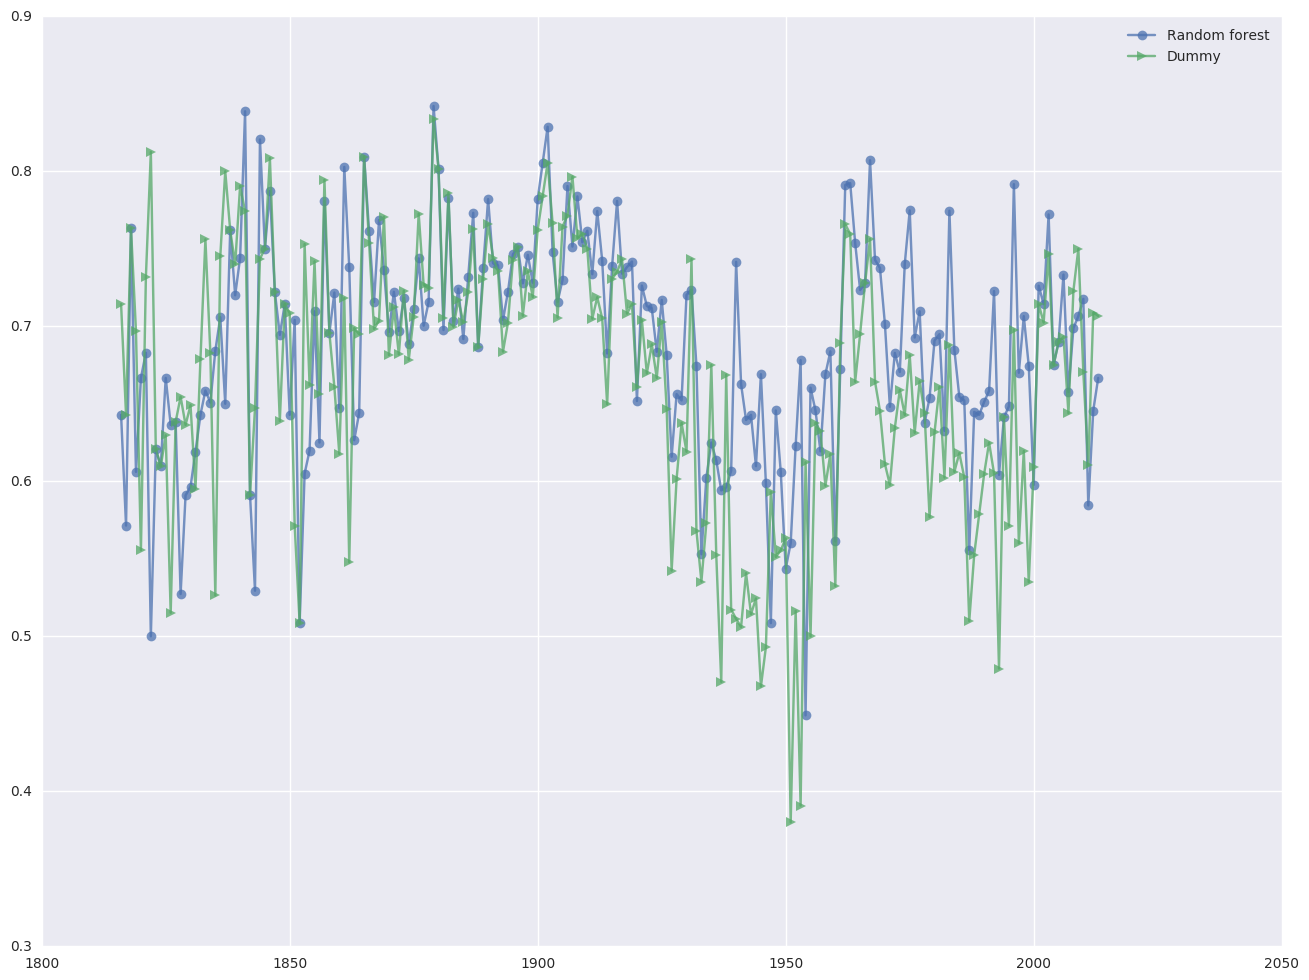

In [220]:
# Setup time series
case_evaluation_index = ~case_data.loc[:, "rf_correct_case"].isnull()
rf_correct_case_ts = case_data.loc[case_evaluation_index, :].groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = case_data.loc[case_evaluation_index, :].groupby("term")["dummy_correct_case"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_case_ts.index, rf_correct_case_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_case_ts.index, dummy_correct_case_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

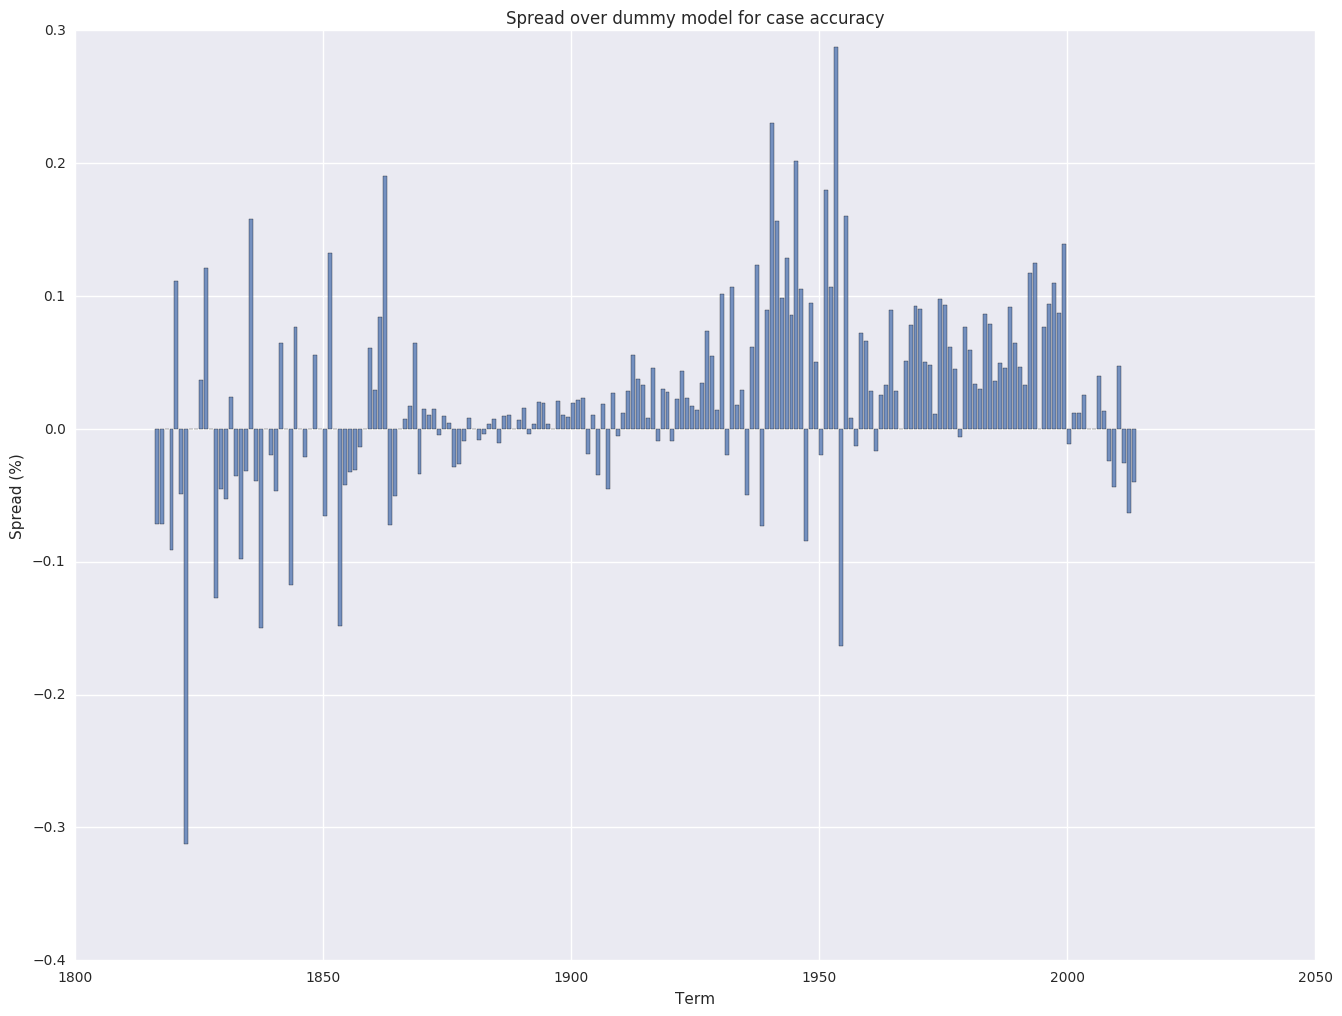

In [221]:
# Setup time series
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_case_ts.index, rf_spread_case_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for case accuracy")

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.expanding_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).sum()
  from ipykernel import kernelapp as app


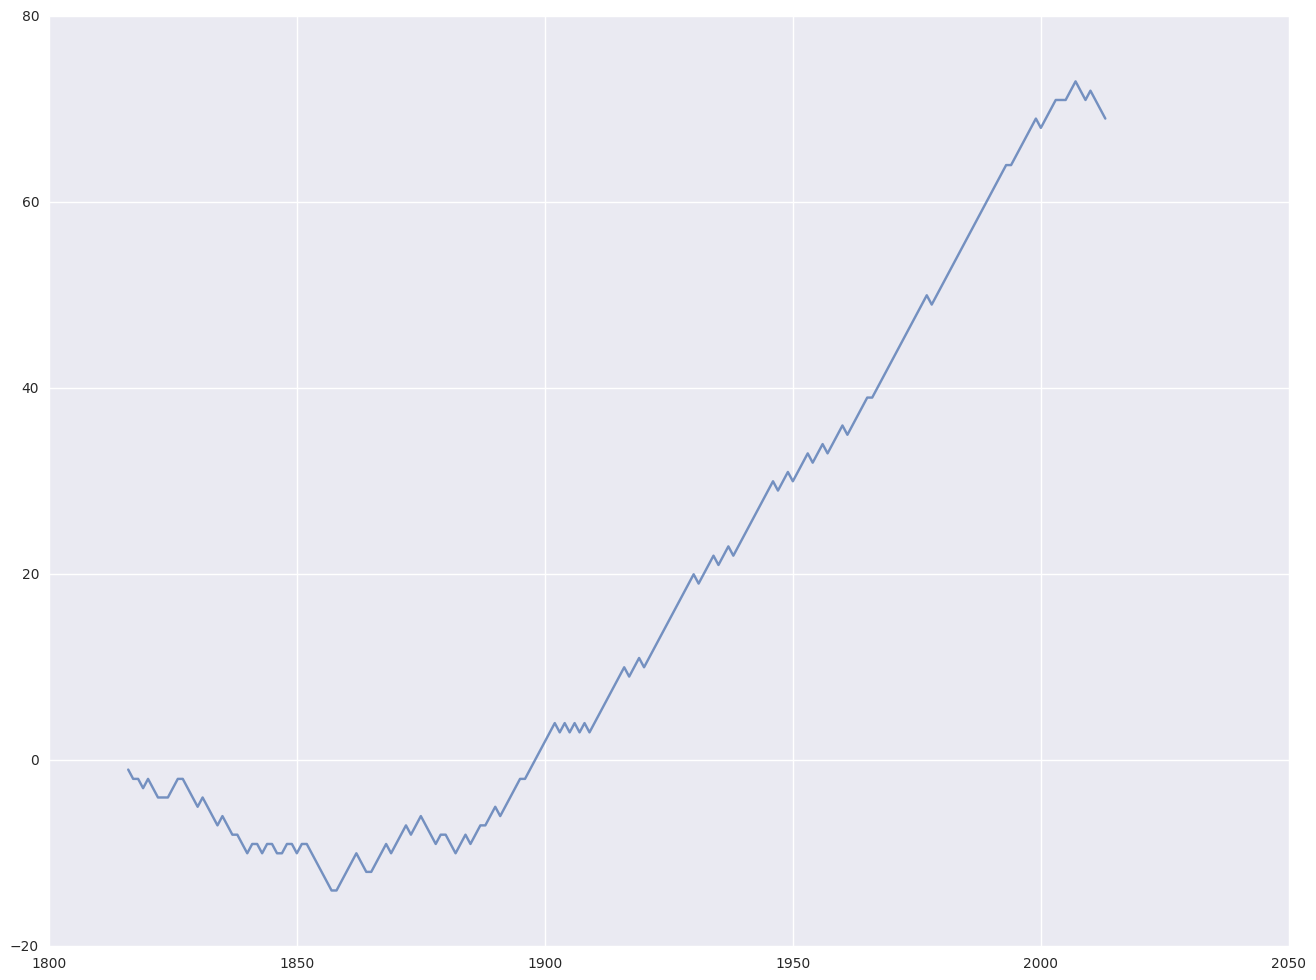

In [222]:
# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts,
        alpha=0.75)

In [223]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(case_data["rf_correct_case"].sum(),
                                              case_data["rf_correct_case"].shape[0],
                                              case_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=4.6462823285216723, pvalue=6.1739382701256857e-06)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=2.2728896379085444, pvalue=0.023032831398928911)
Binomial:
4.84853495406e-22


In [224]:
raw_data.loc[raw_data["caseName"].str.contains("SEBE").fillna(False) &
             raw_data["caseName"].str.contains("BUSI").fillna(False),
             ["term", "docketId", "caseName"]]

,term,docketId,caseName
247725,2011,2011-077-01,"NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e..."
247726,2011,2011-077-01,"NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e..."
247727,2011,2011-077-01,"NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e..."
247728,2011,2011-077-01,"NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e..."
247729,2011,2011-077-01,"NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e..."
247730,2011,2011-077-01,"NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e..."
247731,2011,2011-077-01,"NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e..."
247732,2011,2011-077-01,"NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e..."
247733,2011,2011-077-01,"NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e..."


In [225]:
raw_data.loc[raw_data.loc[:, "caseName"] == "MIRANDA v. ARIZONA", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", 
               "rf_correct", "dummy_correct",
               "rf_reverse_correct", "dummy_reverse_correct",
               "rf_correct_case_case", "dummy_correct_case_case"]].T

,194698,194699,194700,194701,194702,194703,194704,194705,194706
caseName,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA
justiceName,JHarlan2,HLBlack,WODouglas,PStewart,WJBrennan,BRWhite,EWarren,TCClark,AFortas
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,0,1,1,0,1,0,1,0,1
rf_predicted,0,1,1,0,1,0,1,0,1
rf_predicted_score_affirm,0.610824,0.261128,0.178081,0.566175,0.307923,0.493902,0.21479,0.539723,0.391435
rf_predicted_score_reverse,0.349661,0.706407,0.796711,0.40764,0.65577,0.467945,0.74682,0.42809,0.49751
rf_correct,1,1,1,1,1,1,1,1,1
dummy_correct,0,1,1,0,1,0,1,0,1
rf_reverse_correct,1,1,1,1,1,1,1,1,1


In [226]:
raw_data.loc[raw_data.loc[:, "docketId"] == "1972-048-01", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", 
               "rf_correct", "dummy_correct",
               "rf_reverse_correct", "dummy_reverse_correct",
               "rf_correct_case_case", "dummy_correct_case_case"]].T

,203614,203615,203616,203617,203618,203619,203620,203621,203622
caseName,"ROE et al. v. WADE, DISTRICT ATTORNEY OF DALLA...","ROE et al. v. WADE, DISTRICT ATTORNEY OF DALLA...","ROE et al. v. WADE, DISTRICT ATTORNEY OF DALLA...","ROE et al. v. WADE, DISTRICT ATTORNEY OF DALLA...","ROE et al. v. WADE, DISTRICT ATTORNEY OF DALLA...","ROE et al. v. WADE, DISTRICT ATTORNEY OF DALLA...","ROE et al. v. WADE, DISTRICT ATTORNEY OF DALLA...","ROE et al. v. WADE, DISTRICT ATTORNEY OF DALLA...","ROE et al. v. WADE, DISTRICT ATTORNEY OF DALLA..."
justiceName,WODouglas,PStewart,TMarshall,WJBrennan,BRWhite,WEBurger,HABlackmun,LFPowell,WHRehnquist
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,1,1,1,1,0,1,1,1,0
rf_predicted,1,1,1,1,1,0,0,0,0
rf_predicted_score_affirm,0.196591,0.394687,0.23445,0.218263,0.404791,0.503216,0.477924,0.474186,0.506709
rf_predicted_score_reverse,0.755582,0.536734,0.715692,0.729258,0.529971,0.441301,0.463619,0.451601,0.422625
rf_correct,1,1,1,1,0,0,0,0,1
dummy_correct,1,1,1,1,0,1,1,1,0
rf_reverse_correct,1,1,1,1,0,0,0,0,1


In [227]:
raw_data.loc[raw_data.loc[:, "docketId"] == "2011-077-01", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", 
               "rf_correct", "dummy_correct",
               "rf_reverse_correct", "dummy_reverse_correct",
               "rf_correct_case_case", "dummy_correct_case_case"]].T

,247725,247726,247727,247728,247729,247730,247731,247732,247733
caseName,"NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e...","NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e...","NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e...","NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e...","NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e...","NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e...","NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e...","NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e...","NATIONAL FEDERATION OF INDEPENDENT BUSINESS, e..."
justiceName,JGRoberts,AScalia,AMKennedy,CThomas,RBGinsburg,SGBreyer,SAAlito,SSotomayor,EKagan
case_outcome_disposition,0,0,0,0,0,0,0,0,0
justice_outcome_disposition,0,1,1,1,0,0,1,0,0
rf_predicted,1,1,1,1,1,1,1,1,1
rf_predicted_score_affirm,0.452738,0.454902,0.439275,0.487904,0.367541,0.378953,0.48184,0.353103,0.457458
rf_predicted_score_reverse,0.527347,0.529613,0.545149,0.493873,0.619002,0.603393,0.502122,0.632471,0.522485
rf_correct,0,1,1,1,0,0,1,0,0
dummy_correct,0,1,1,1,0,0,1,0,0
rf_reverse_correct,0,1,1,1,0,0,1,0,0


In [228]:
raw_data.loc[raw_data.loc[:, "docketId"] == "1895-271-01", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", 
               "rf_correct", "dummy_correct",
               "rf_reverse_correct", "dummy_reverse_correct",
               "rf_correct_case_case", "dummy_correct_case_case"]].T

,86530,86531,86532,86533,86534,86535,86536,86537,86538
caseName,PLESSY v. FERGUSON,PLESSY v. FERGUSON,PLESSY v. FERGUSON,PLESSY v. FERGUSON,PLESSY v. FERGUSON,PLESSY v. FERGUSON,PLESSY v. FERGUSON,PLESSY v. FERGUSON,PLESSY v. FERGUSON
justiceName,MWFuller,SJField,JHarlan1,HGray,DJBrewer,HBBrown,GShiras,EDEWhite,RWPeckham
case_outcome_disposition,0,0,0,0,0,0,0,0,0
justice_outcome_disposition,0,0,1,0,-1,0,0,0,0
rf_predicted,-1,-1,-1,-1,-1,-1,-1,-1,-1
rf_predicted_score_affirm,0.327622,0.321317,0.330945,0.346858,0.351123,0.335789,0.336084,0.326083,0.365128
rf_predicted_score_reverse,0.232932,0.216896,0.214441,0.2163,0.222245,0.239588,0.217537,0.229434,0.209143
rf_correct,0,0,0,0,1,0,0,0,0
dummy_correct,1,1,0,1,0,1,1,1,1
rf_reverse_correct,1,1,0,1,1,1,1,1,1


In [229]:
# Output file data
raw_data.to_csv("../data/output/scdb_legacy_raw_data_most_frequent_trailing_cv_{0}.csv".format(file_timestamp))
case_accuracy_data.to_csv("../data/output/scdb_legacy_case_data_most_frequent_trailing_cv_{0}.csv".format(file_timestamp))
feature_importance_df.to_csv("../data/output/scdb_legacy_last_features_most_frequent_trailing_cv_{0}.csv".format(file_timestamp))

In [230]:
# Setup feature importance TS
feature_importance_ts = feature_importance_df.groupby(["term", "feature"])["importance"].mean().unstack()
feature_importance_ts.to_csv("../data/output/scdb_legacy_feature_weight_ts_most_frequent_trailing_cv_{0}.csv".format(file_timestamp))

In [253]:
# Counts
raw_data.loc[evaluation_index, "justice_outcome_disposition"].value_counts()

 0    113454
 1     93161
-1     37267
Name: justice_outcome_disposition, dtype: int64

In [257]:
raw_data.loc[evaluation_index, "justice_outcome_disposition"].shape

(243882,)

In [256]:
#case_data.head()
case_data.loc[:, "case_outcome_reverse"].value_counts()

0    16718
1    11291
Name: case_outcome_reverse, dtype: int64

In [258]:
case_data.loc[:, "case_outcome_reverse"].shape

(28009,)

In [273]:
raw_data.loc[raw_data["term"].between(1980, 2015), "justice_outcome_reverse"].describe()

count    34484.000000
mean         0.573860
std          0.494522
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: justice_outcome_reverse, dtype: float64

In [274]:
case_data.loc[case_data["term"].between(1980, 2015), "case_outcome_reverse"].describe()

count    3765.000000
mean        0.628951
std         0.483150
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: case_outcome_reverse, dtype: float64

In [268]:
# Agreement comparison
raw_data.loc[raw_data.loc[:, "justiceName"].str.lower().str.contains("kagan"),
            "justice_outcome_reverse"].describe()

count    387.000000
mean       0.576227
std        0.494795
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: justice_outcome_reverse, dtype: float64

In [278]:
case_data.loc[:, "term_decade"] = (case_data["term"] / 10).astype(int) * 10.0
case_data.head().T

docketId,1816-001-01,1816-002-01,1816-003-01,1816-004-01,1816-005-01
rf_predicted_case,1,0,0,1,0
dummy_predicted_case,0,0,0,0,0
case_outcome_reverse,0,0,0,0,0
term,1816,1816,1816,1816,1816
naturalCourt,406,406,406,406,406
rf_correct_case,0,1,1,0,1
dummy_correct_case,1,1,1,1,1
docketId,1816-001-01,1816-002-01,1816-003-01,1816-004-01,1816-005-01
term_decade,1810,1810,1810,1810,1810


term_decade
1930    0.409512
1940    0.508651
Name: case_outcome_reverse, dtype: float64

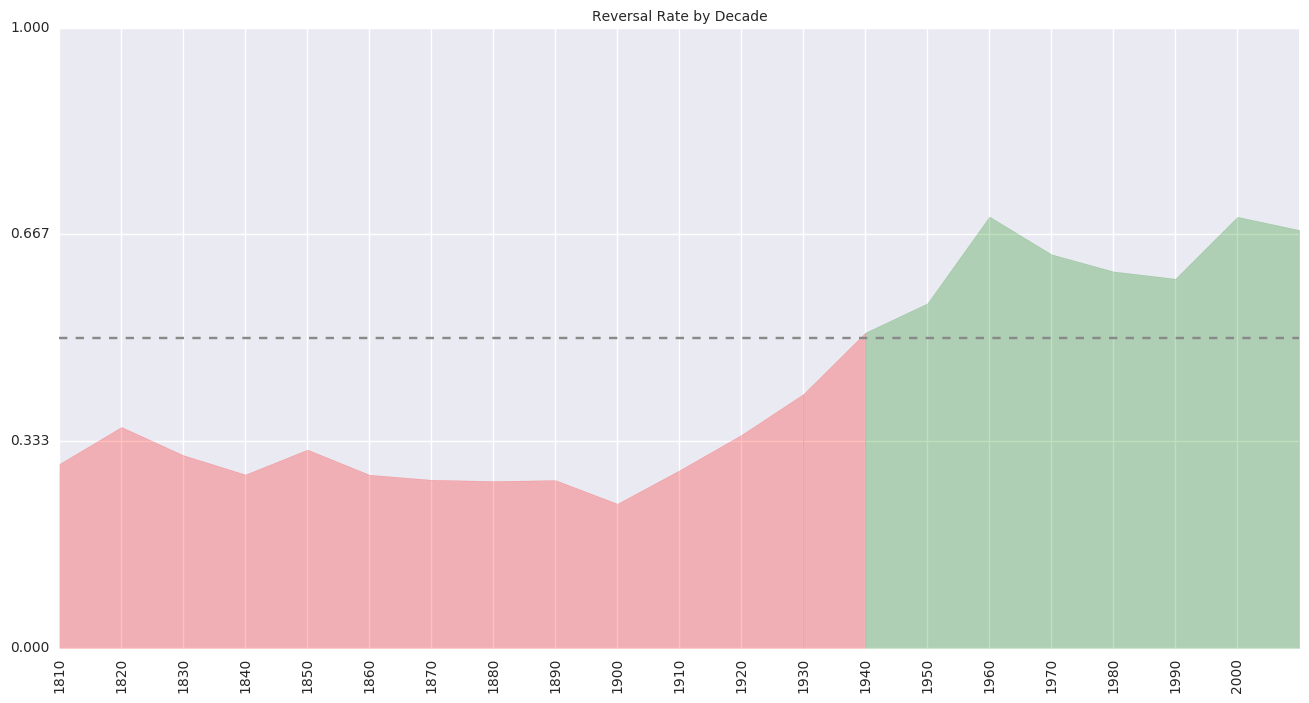

In [312]:
decade_reverse_rate = case_data.groupby("term_decade")["case_outcome_reverse"].mean()

# Setup grid
f = plt.figure(figsize=(16,8))
ax = plt.gca()

# Handle justice accuracy
ax_id = 0
column_name = "Reversal Rate by Decade"

# Setup title and data
ax.set_title("{0}".format(column_name), fontsize=10)
ts_data = decade_reverse_rate
min_term = int(ts_data.index.min())
max_term = int(ts_data.index.max())
min_val = 0.0
max_val = 1.0

# Plot fill and marker
ax.axhline(0.5, linestyle='--', color='#898989') # horizontal lines
ax.fill_between(ts_data.index, 0, ts_data, where=(ts_data >= 0.5), alpha=0.25, color="green", interpolate=False)
ax.fill_between(ts_data.index, 0, ts_data, where=(ts_data <= 0.5), alpha=0.25, color="red", interpolate=False)
ax.fill_between(ts_data.loc[[1930,1940]].index, 0, ts_data.loc[[1930,1940]], alpha=0.25, color="red", interpolate=False)

# Setup axes
_ = ax.set_xlim(min_term, max_term)
_ = ax.set_xticks(numpy.arange(min_term, max_term, 10))
_ = ax.set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
_ = ax.set_ylim(min_val, max_val)
_ = ax.set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))


# Save as PNG, PDF, and SVG
plt.savefig("../figures/decade_reversal_rate_{0}.png".format(file_timestamp))
plt.savefig("../figures/decade_reversal_rate_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/decade_reversal_rate_{0}.svg".format(file_timestamp))

## Justice Vote Confusion Matrix

In [231]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"].astype(int)

# Compare model
print("RF model")
print("="*32)
justice_confusion_df = pandas.DataFrame(sklearn.metrics.confusion_matrix(target_actual, target_predicted), columns=["Other", "Affirm", "Reverse"], index=["Other", "Affirm", "Reverse"])
justice_confusion_df

RF model


,Other,Affirm,Reverse
Other,23588,11344,4589
Affirm,3151,88443,21860
Reverse,1856,44984,46321


In [232]:
print(justice_confusion_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Other &  Affirm &  Reverse \\
\midrule
Other   &  23588 &   11344 &     4589 \\
Affirm  &   3151 &   88443 &    21860 \\
Reverse &   1856 &   44984 &    46321 \\
\bottomrule
\end{tabular}



In [233]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
reverse_target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"] > 0).astype(int)
reverse_target_predicted = (raw_data.loc[evaluation_index, "rf_predicted"] > 0).astype(int)
reverse_target_dummy = (raw_data.loc[evaluation_index, "dummy_predicted"] > 0).astype(int)

# Compare model
print("RF model")
print("="*32)
justice_reverse_confusion_df = pandas.DataFrame(sklearn.metrics.confusion_matrix(reverse_target_actual, reverse_target_predicted), columns=["Affirm", "Reverse"], index=["Affirm", "Reverse"])
justice_reverse_confusion_df

RF model


,Affirm,Reverse
Affirm,126526,26449
Reverse,46840,46321


In [234]:
print(justice_reverse_confusion_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Affirm &  Reverse \\
\midrule
Affirm  &  126526 &    26449 \\
Reverse &   46840 &    46321 \\
\bottomrule
\end{tabular}



## Case Vote Confusion Matrix

In [235]:
# Output comparison
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = (raw_data.loc[evaluation_index, "case_outcome_disposition"] > 0).astype(int)
target_predicted = (raw_data.loc[evaluation_index, "rf_predicted_case"] > 0).astype(int)
target_dummy = (raw_data.loc[evaluation_index, "dummy_predicted_case"] > 0).astype(int)

raw_data.loc[:, "rf_correct_case"] = numpy.nan
raw_data.loc[:, "dummy_correct_case"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
case_confusion_df = pandas.DataFrame(sklearn.metrics.confusion_matrix(target_actual, target_predicted), columns=["Affirm", "Reverse"], index=["Affirm", "Reverse"])
case_confusion_df

RF model


,Affirm,Reverse
Affirm,119575,24574
Reverse,51537,48196


In [236]:
print(case_confusion_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Affirm &  Reverse \\
\midrule
Affirm  &  119575 &    24574 \\
Reverse &   51537 &    48196 \\
\bottomrule
\end{tabular}



## Justice Vote Performance against Base Model

In [237]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=4.6462823285216723, pvalue=6.1739382701256857e-06)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=2.2728896379085444, pvalue=0.023032831398928911)
Binomial:
1.0


## Case Vote Performance against Base Model

In [238]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=4.6462823285216723, pvalue=6.1739382701256857e-06)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=2.2728896379085444, pvalue=0.023032831398928911)
Binomial:
1.0


## Feature Weights

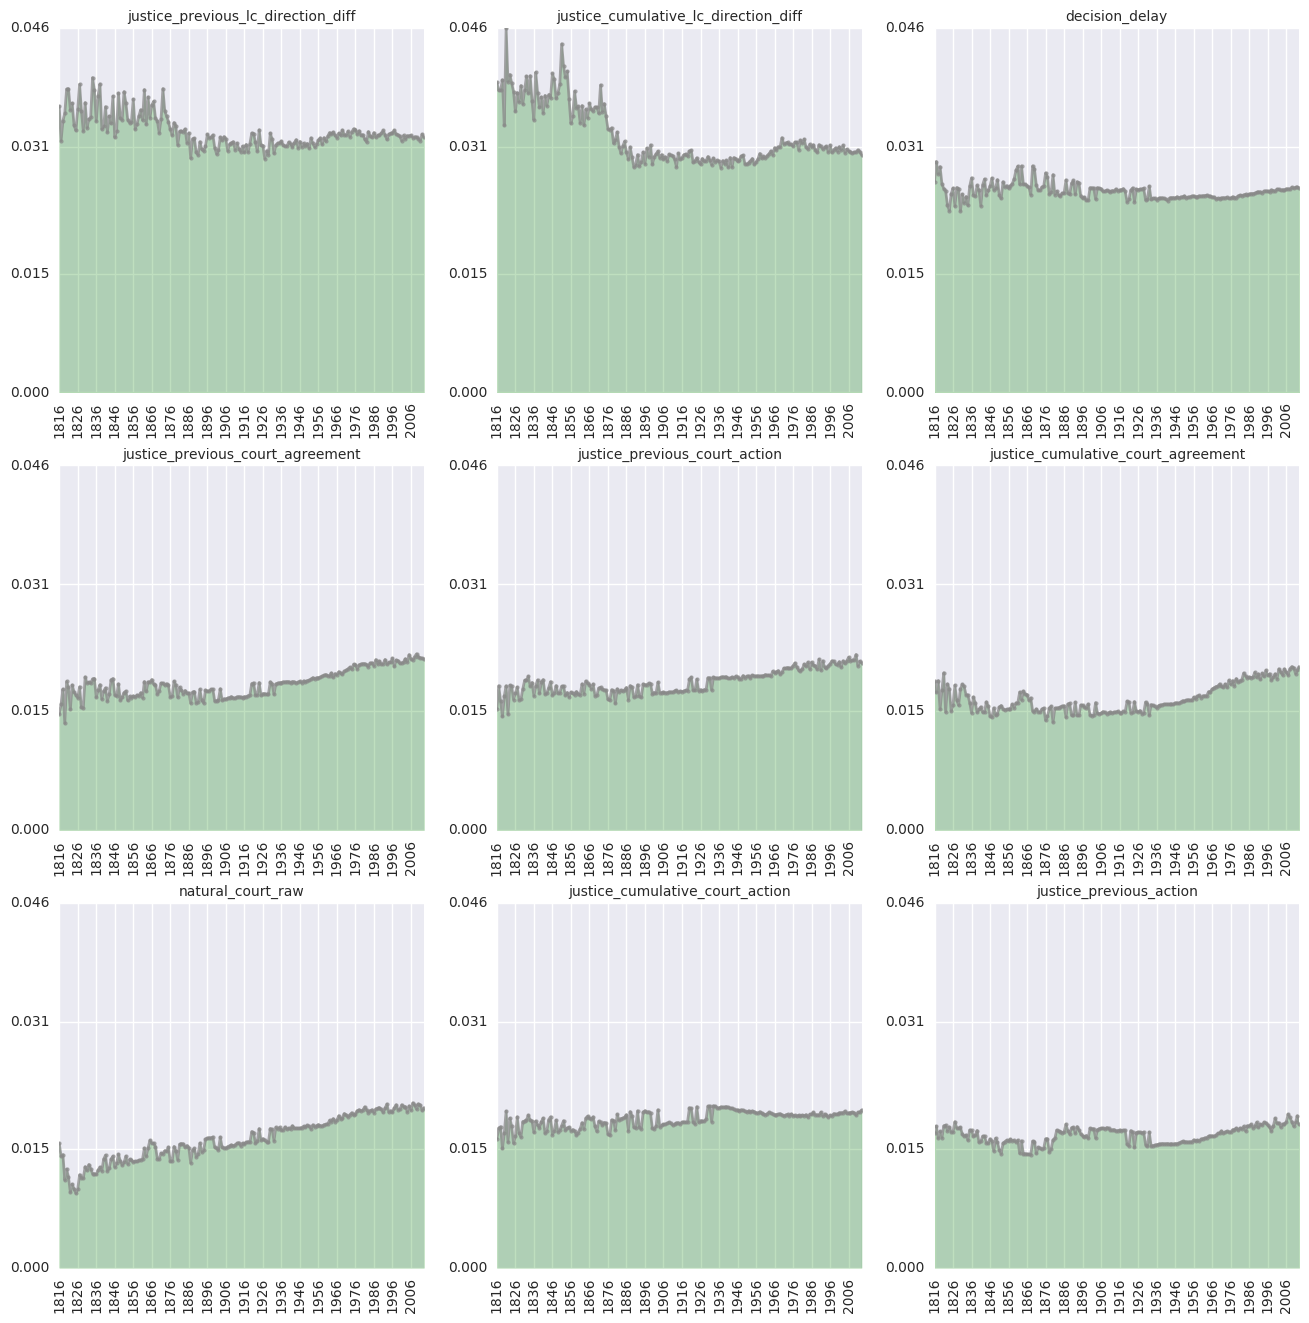

In [239]:
# Get last step weights
num_feature_rows = 3
num_feature_cols = 3
num_feature_total = num_feature_rows * num_feature_cols
last_step = feature_importance_ts.tail(1).T
last_step_top_features = last_step.sort_values(last_step.columns[0], ascending=False).head(num_feature_total).index.tolist()

# Get axis data
min_term = feature_importance_df["term"].min()
max_term = feature_importance_df["term"].max()
min_val = feature_importance_df["importance"].min()
max_val = feature_importance_df["importance"].max()

# Setup grid
#f = plt.figure(figsize=(16, 16))
f, ax = plt.subplots(num_feature_rows, num_feature_cols, figsize=(16,16))

for i in range(len(last_step_top_features)):
    # Get iteration indices
    row_id = int(i / num_feature_cols)
    col_id = (i % num_feature_cols)
    feature_name = last_step_top_features[i]
    
    # Setup title and data
    ax[row_id, col_id].set_title("{0}".format(feature_name), fontsize=10)
    ts_data = feature_importance_ts.loc[:, feature_name]
    
    # Plot fill and marker
    ax[row_id, col_id].fill_between(ts_data.index, 0, ts_data, alpha=0.25, color="green")
    ax[row_id, col_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)
    
    # Setup axes
    ax[row_id, col_id].set_xlim(min_term, max_term)
    ax[row_id, col_id].set_xticks(numpy.arange(min_term, max_term, 10))
    ax[row_id, col_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
    ax[row_id, col_id].set_ylim(min_val, max_val)
    ax[row_id, col_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_feature_importance_ts_trailing_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_ts_trailing_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_ts_trailing_{0}.svg".format(file_timestamp))

In [240]:
# Setup colormap for all positive-negative heatmaps
red_green_cmap = seaborn.diverging_palette(h_neg=10, h_pos=135, as_cmap=True)

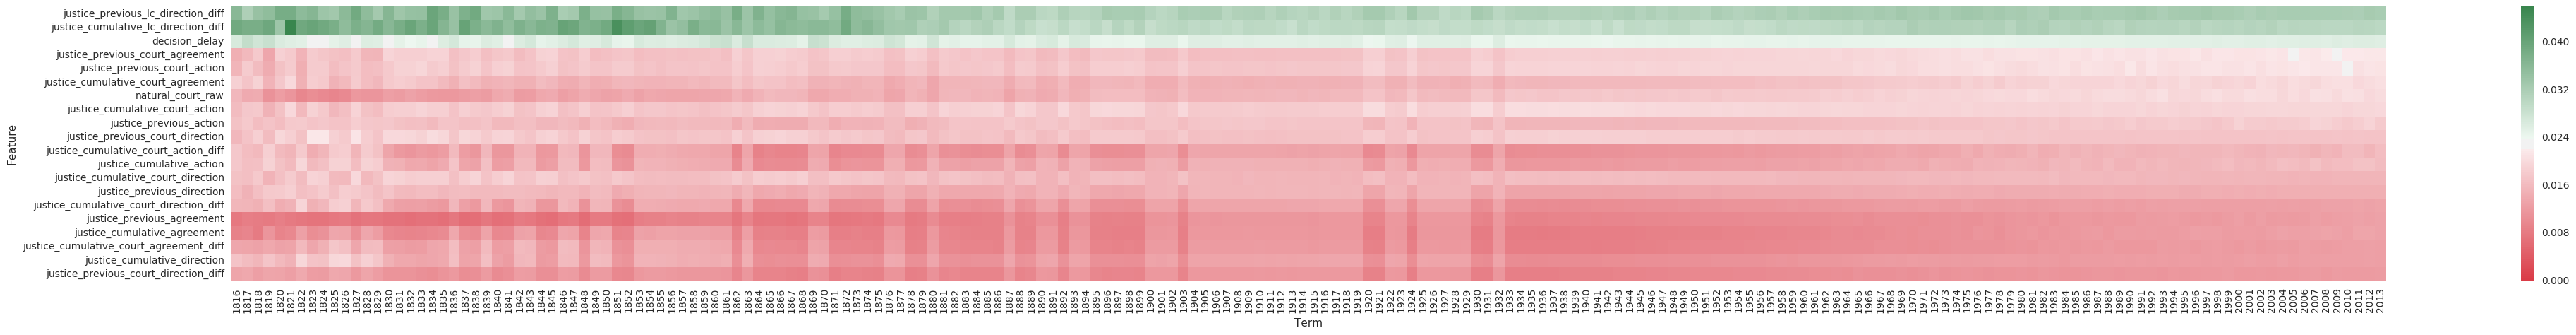

In [241]:
# Top features
num_feature_total = 20
last_step = feature_importance_ts.tail(1).T
last_step_top_features = last_step.sort_values(last_step.columns[0], ascending=False).head(num_feature_total).index.tolist()

# Get axis data
min_term = feature_importance_df["term"].min()
max_term = feature_importance_df["term"].max()
min_val = feature_importance_df["importance"].min()
max_val = feature_importance_df["importance"].max()

# Heatmap
f = plt.figure(figsize=((max_term - min_term) / 4, num_feature_total / 4))
seaborn.heatmap(feature_importance_ts.loc[:, last_step_top_features].T, vmin=0, vmax=max_val, cmap=red_green_cmap)
plt.xlabel("Term")
plt.ylabel("Feature")

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_feature_importance_heatmap_trailing_cv_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_heatmap_trailing_cv_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_heatmap_trailing_cv_{0}.svg".format(file_timestamp))

## Justice Accuracy Heatmap

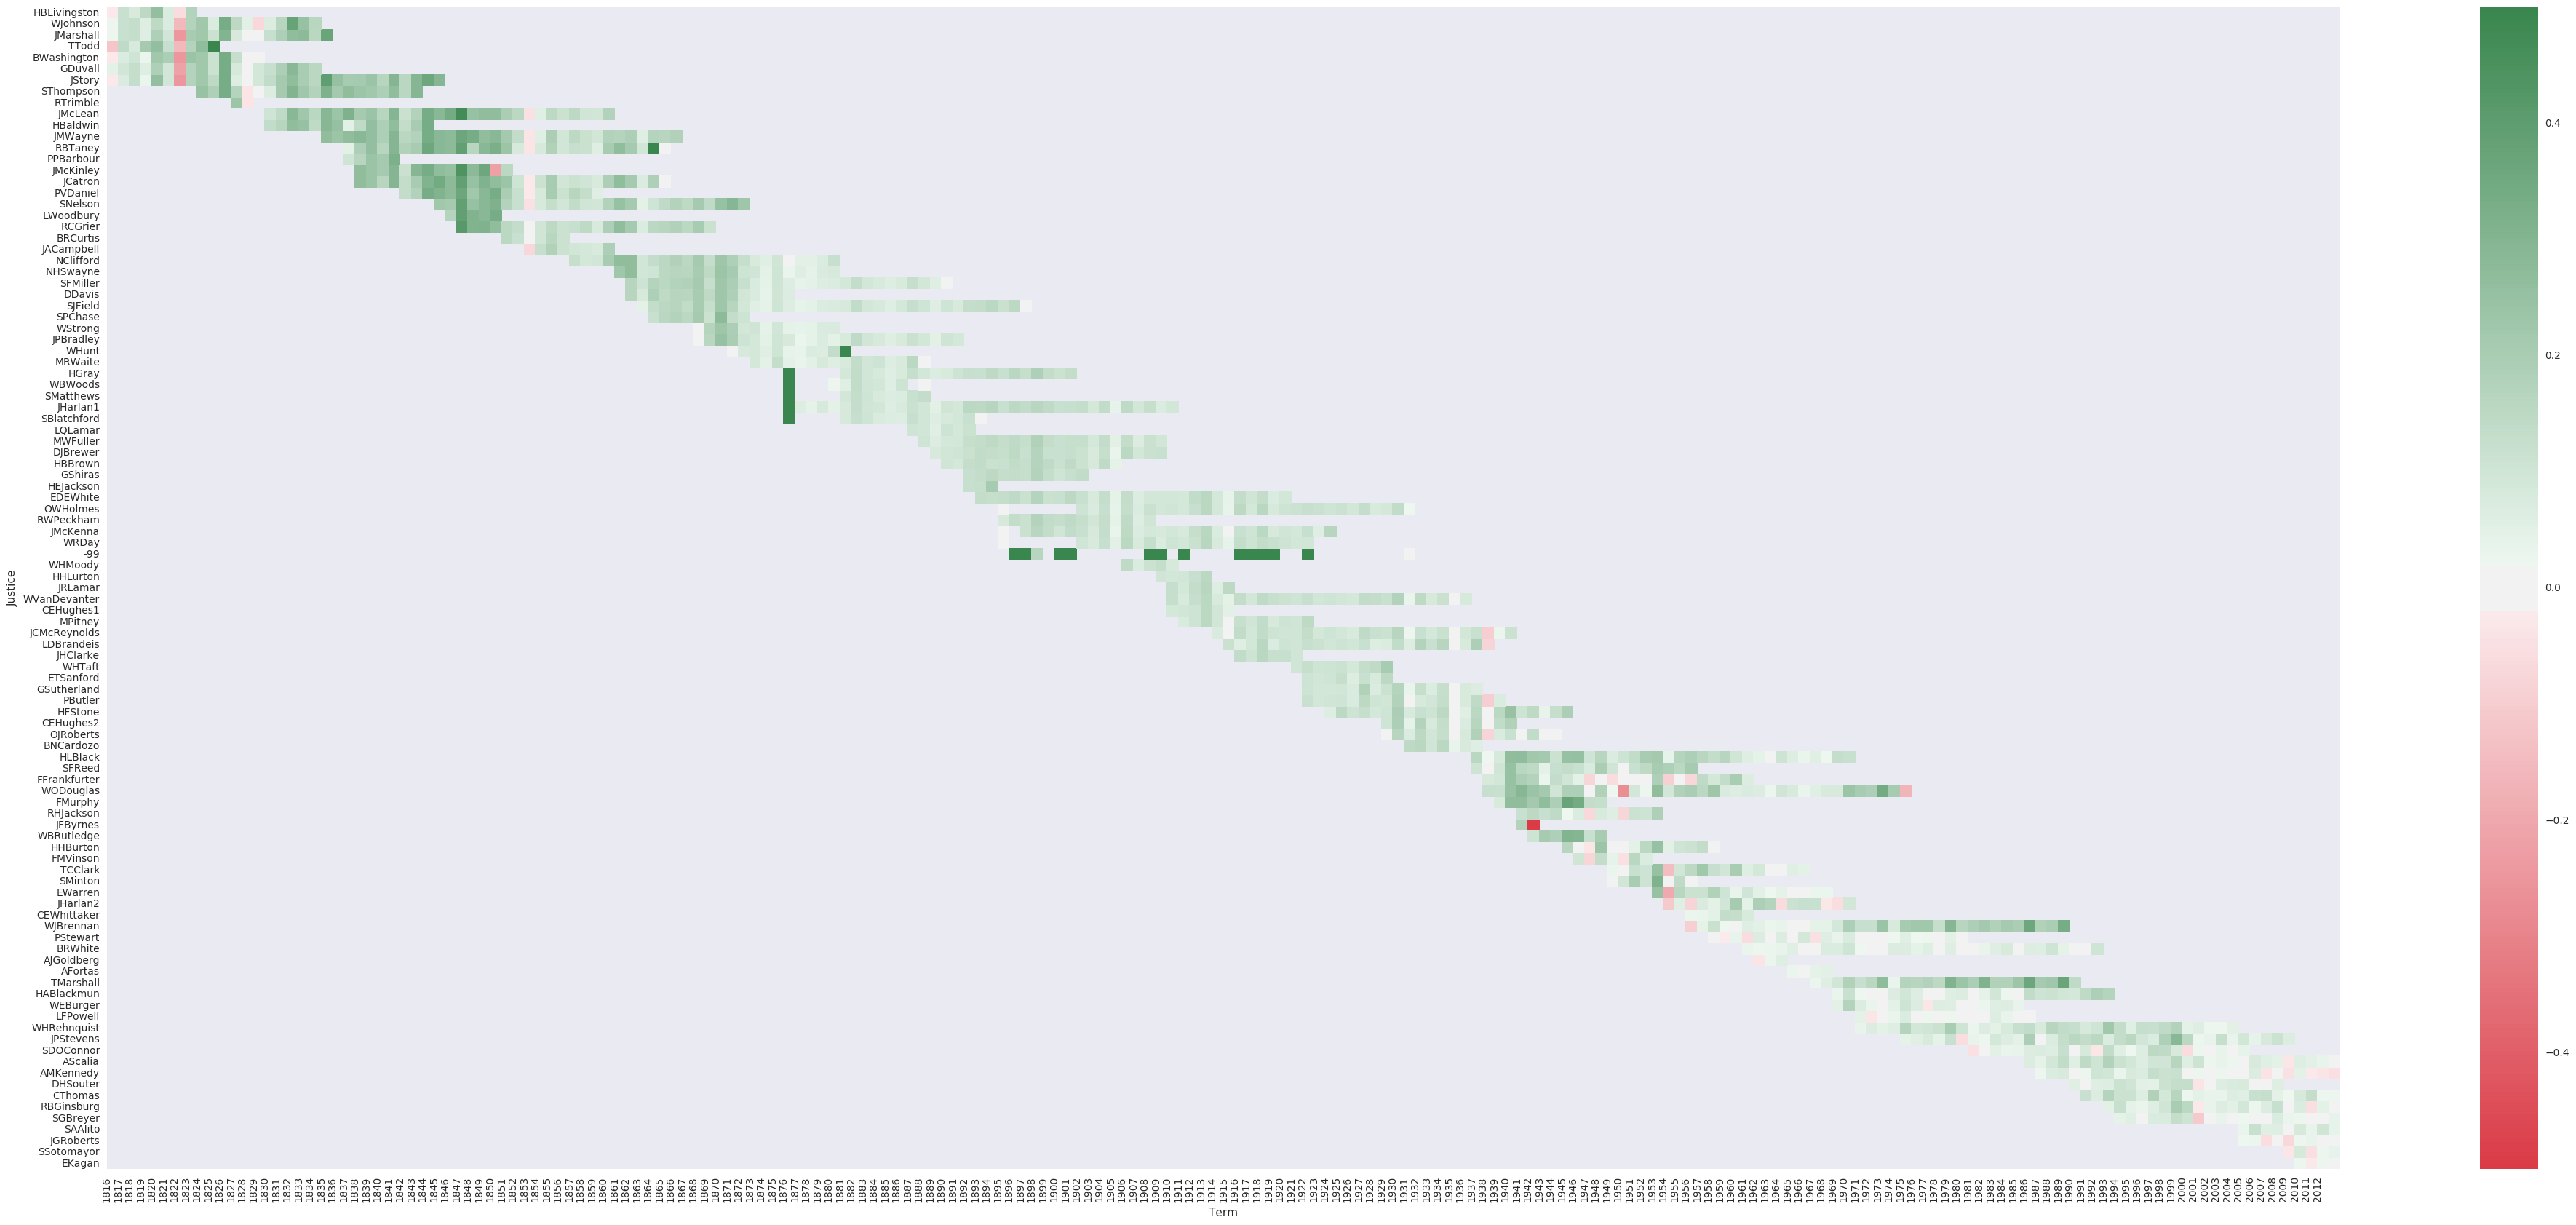

In [242]:
# Setup grouping over evaluation index
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
justice_order = raw_data.loc[evaluation_index, :].groupby(["justiceName"])["term"].min().sort_values().index.tolist()
justice_accuracy_ts = raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["rf_correct"].mean().unstack() - \
    raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["dummy_correct"].mean().unstack()
min_term = min(justice_accuracy_ts.index)
max_term = max(justice_accuracy_ts.index)
    
# Setup plot
num_justices = justice_accuracy_ts.shape[1]
num_years = justice_accuracy_ts.shape[0]
f, ax = plt.subplots(figsize=(num_years / 4, num_justices / 5))
seaborn.heatmap(justice_accuracy_ts.loc[:, justice_order].T, vmin=-0.5, vmax=0.5, ax=ax, cmap=red_green_cmap)

# Setup labels
_ = ax.set_xticks(numpy.arange(0, max_term - min_term, 1))
_ = ax.set_xticklabels(map(str, numpy.arange(min_term, max_term, 1)), rotation=90)
ax.set_xlabel("Term")
ax.set_ylabel("Justice")

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_justice_accuracy_heatmap_trailing_cv_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_heatmap_trailing_cv_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_heatmap_trailing_cv_{0}.svg".format(file_timestamp))

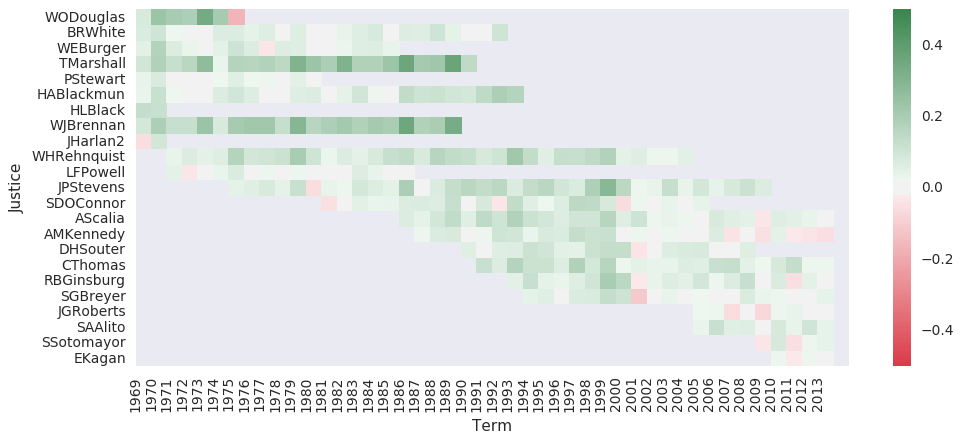

In [243]:
# Setup grouping over evaluation index
evaluation_index = (raw_data.loc[:, "naturalCourt"] >= 1500) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
justice_order = raw_data.loc[evaluation_index, :].groupby(["justiceName"])["term"].min().sort_values().index.tolist()
justice_accuracy_ts = raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["rf_correct"].mean().unstack() - \
    raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["dummy_correct"].mean().unstack()
min_term = min(justice_accuracy_ts.index)
max_term = max(justice_accuracy_ts.index)
    
# Setup plot
num_justices = justice_accuracy_ts.shape[1]
num_years = justice_accuracy_ts.shape[0]
f, ax = plt.subplots(figsize=(num_years / 4, num_justices / 5))
seaborn.heatmap(justice_accuracy_ts.loc[:, justice_order].T, vmin=-0.5, vmax=0.5, ax=ax, cmap=red_green_cmap)

# Setup labels
_ = ax.set_xticks(numpy.arange(0, max_term - min_term, 1))
_ = ax.set_xticklabels(map(str, numpy.arange(min_term, max_term, 1)), rotation=90)
ax.set_xlabel("Term")
ax.set_ylabel("Justice")

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_justice_accuracy_post_burger_heatmap_trailing_cv_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_post_burger_heatmap_trailing_cv_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_post_burger_heatmap_trailing_cv_{0}.svg".format(file_timestamp))

## Performance by vote configurations

In [244]:
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
case_config_data = []

for docket_id, docket_data in raw_data.loc[evaluation_index, :].groupby("docketId"):
    # Avoid very irregular cases
    if docket_data.shape[0] > 9:
        continue
    
    # Setup description
    vote_counts = docket_data.loc[:, "justice_outcome_disposition"].value_counts()
    reverse_count = vote_counts.ix[1] if 1 in vote_counts.index else 0
    affirm_count = docket_data.shape[0] - reverse_count
    if reverse_count > affirm_count:
        config_string = "{0}-{1} reverse".format(reverse_count, affirm_count)
    else:
        config_string = "{0}-{1} affirm".format(affirm_count, reverse_count)
        
    # Setup predicted
    vote_counts_predicted = docket_data.loc[:, "rf_predicted"].value_counts()
    reverse_count_predicted = vote_counts_predicted.ix[1] if 1 in vote_counts_predicted.index else 0
    affirm_count_predicted = docket_data.shape[0] - reverse_count_predicted
    if reverse_count_predicted > affirm_count_predicted:
        config_string_predicted = "{0}-{1} reverse".format(reverse_count_predicted, affirm_count_predicted)
        case_outcome_predicted = 1
    else:
        config_string_predicted = "{0}-{1} affirm".format(affirm_count_predicted, reverse_count_predicted)
        case_outcome_predicted = 0
        
    # Setup dummy
    vote_counts_dummy = docket_data.loc[:, "dummy_predicted"].value_counts()
    reverse_count_dummy = vote_counts_dummy.ix[1] if 1 in vote_counts_dummy.index else 0
    affirm_count_dummy = docket_data.shape[0] - reverse_count_dummy
    if reverse_count_dummy > affirm_count_dummy:
        config_string_dummy = "{0}-{1} reverse".format(reverse_count_dummy, affirm_count_dummy)
        case_outcome_dummy = 1
    else:
        config_string_dummy = "{0}-{1} affirm".format(affirm_count_dummy, reverse_count_dummy)
        case_outcome_dummy = 0
    
    # Print
    case_config_data.append((docket_id, docket_data.loc[:, "term"].values[0], config_string, 
                             int(docket_data.loc[:, "case_outcome_disposition"].values[0] > 0),
                            config_string_predicted, case_outcome_predicted,
                            config_string_dummy, case_outcome_dummy))

# Setup as DF
case_config_df = pandas.DataFrame(case_config_data, columns=["docket_id", "term", 
                                                             "actual_configuration", "actual_outcome", 
                                                             "predicted_configuration", "predicted_outcome",
                                                            "dummy_configuration", "dummy_outcome"])
case_config_df.loc[:, "rf_correct"] = (case_config_df["actual_outcome"] == case_config_df["predicted_outcome"]).astype(int)
case_config_df.loc[:, "dummy_correct"] = (case_config_df["actual_outcome"] == case_config_df["dummy_outcome"]).astype(int)
case_config_df.set_index(case_config_df["docket_id"], inplace=True)

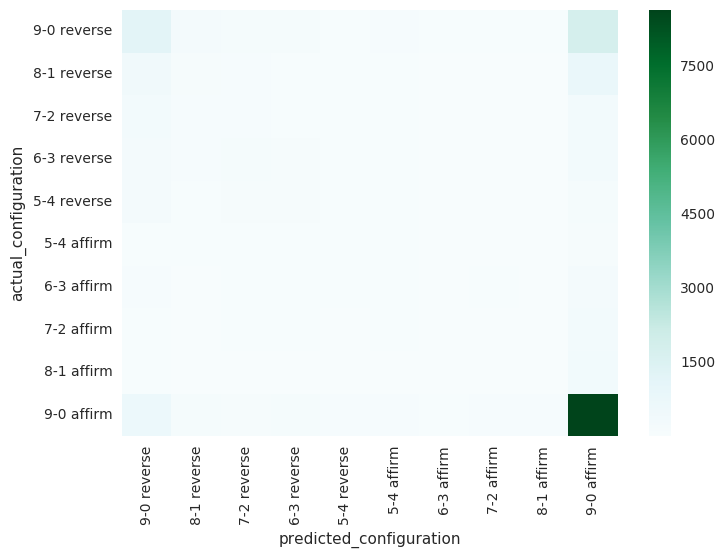

In [245]:
all_configuration_crosstab = pandas.crosstab(case_config_df["actual_configuration"], case_config_df["predicted_configuration"])
configuration_list = ['9-0 reverse',
                      '8-1 reverse',
                      '7-2 reverse',
                      '6-3 reverse',
                      '5-4 reverse',
                      '5-4 affirm',
                      '6-3 affirm',
                      '7-2 affirm',
                      '8-1 affirm',
                      '9-0 affirm'
                     ]
seaborn.heatmap(all_configuration_crosstab.loc[configuration_list, configuration_list], cmap="BuGn")

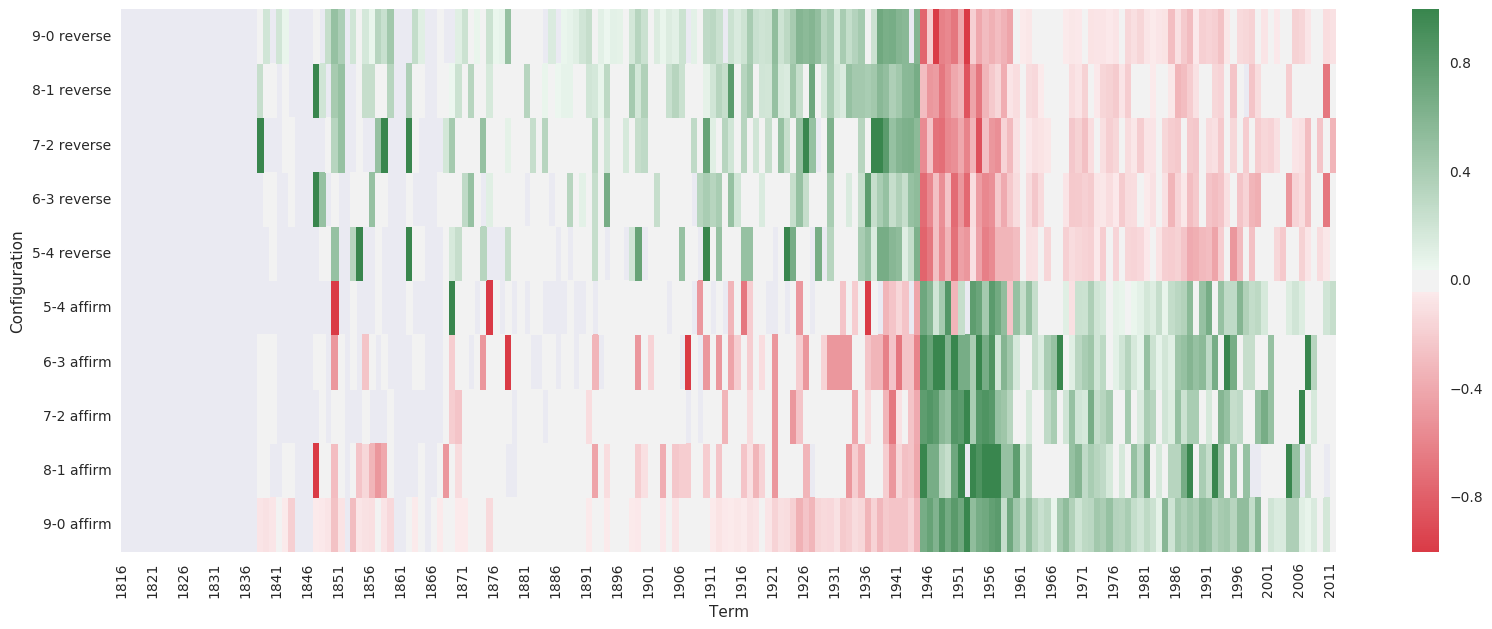

In [246]:
# Re-shape average correct
case_config_ts = case_config_df.groupby(["term", "actual_configuration"])["rf_correct"].mean().unstack() - \
    case_config_df.groupby(["term", "actual_configuration"])["dummy_correct"].mean().unstack()
min_term = min(case_config_ts.index)
max_term = max(case_config_ts.index)

# Setup plot
num_configs = case_config_ts.shape[1]
num_years = case_config_ts.shape[0]
f, ax = plt.subplots(figsize=(num_years / 10, num_configs / 5))
seaborn.heatmap(case_config_ts.loc[:, configuration_list].T, cmap=red_green_cmap)

# Setup labels
_ = ax.set_xticks(numpy.arange(0, max_term - min_term, 5))
_ = ax.set_xticklabels(map(str, numpy.arange(min_term, max_term, 5)), rotation=90)
ax.set_xlabel("Term")
ax.set_ylabel("Configuration")

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_configuration_accuracy_heatmap_trailing_cv_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_configuration_accuracy_heatmap_trailing_cv_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_configuration_accuracy_heatmap_trailing_cv_{0}.svg".format(file_timestamp))

## Overall Performance Comparison

In [247]:
# Combine series into one yearly TS
annual_ts = pandas.DataFrame([rf_correct_ts, dummy_correct_ts, rf_correct_case_ts, dummy_correct_case_ts]).T
annual_ts.loc[:, "term"] = annual_ts.index
annual_ts.head()
annual_ts_melt = pandas.melt(annual_ts, id_vars=["term"])

# Now plot stacked
#seaborn.barplot(x="term", y="value", hue="variable", data=annual_ts_melt)

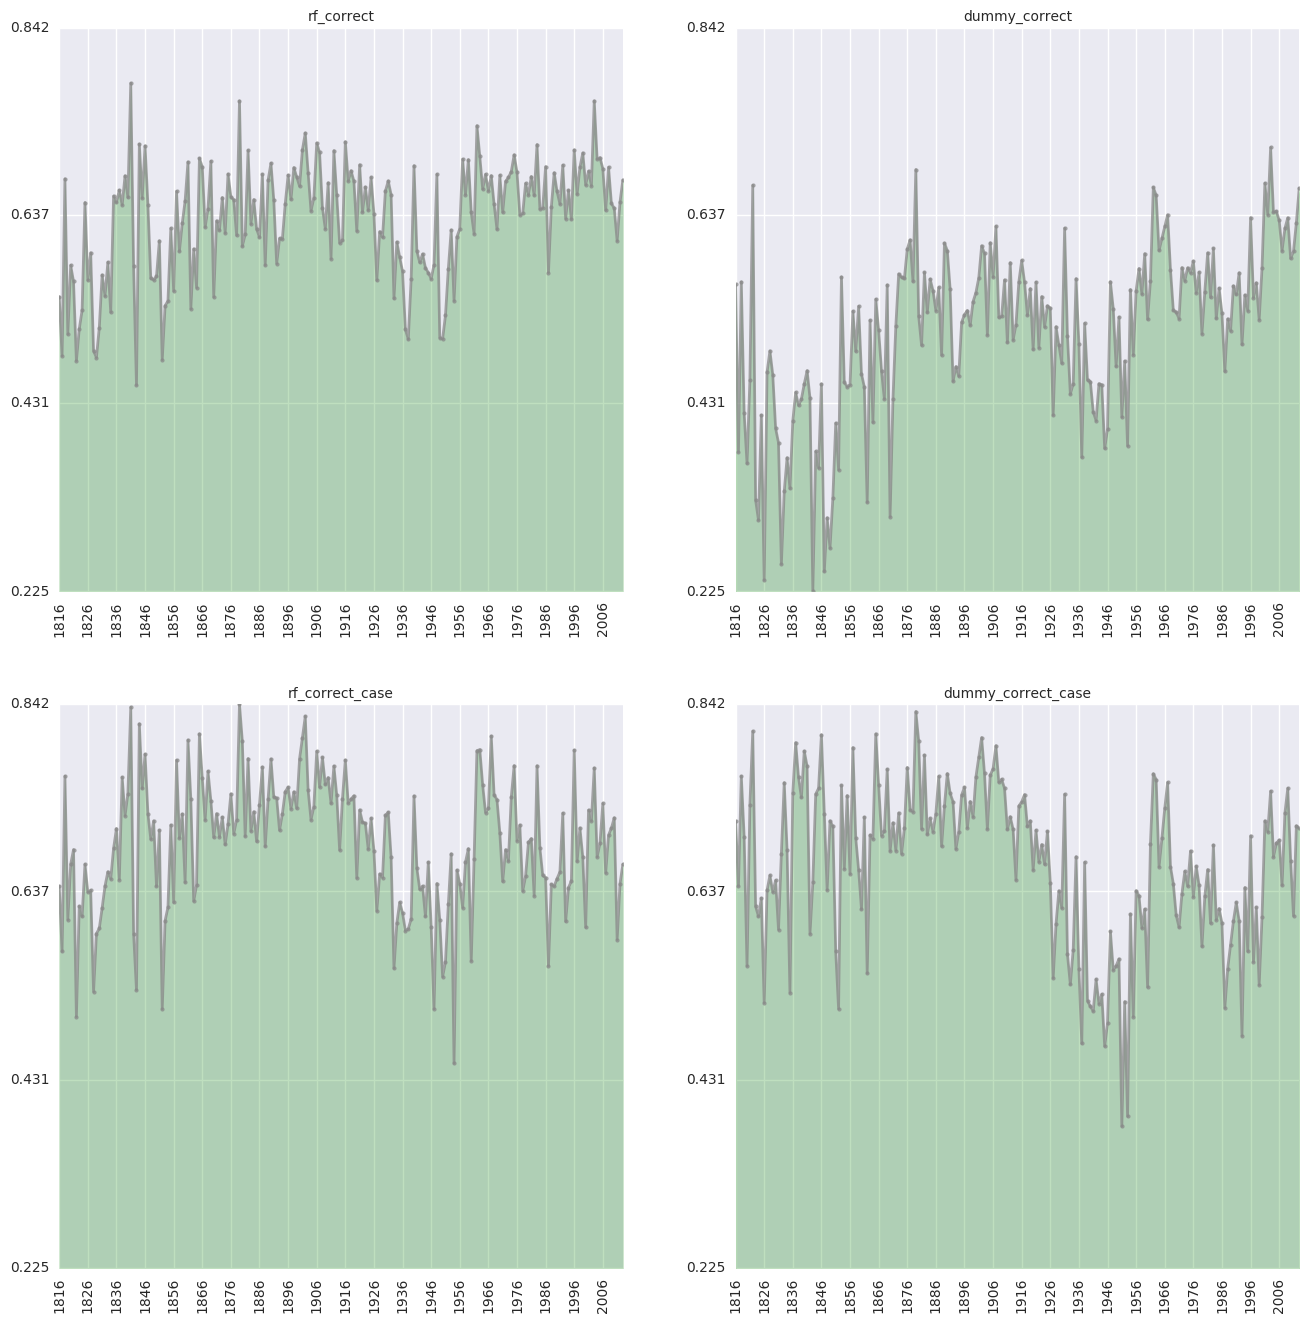

In [248]:
# Get last step weights
num_feature_rows = 2
num_feature_cols = 2
num_feature_total = num_feature_rows * num_feature_cols

# Get axis data
min_term = annual_ts_melt["term"].min()
max_term = annual_ts_melt["term"].max()
min_val = annual_ts_melt["value"].min()
max_val = annual_ts_melt["value"].max()

# Setup grid
#f = plt.figure(figsize=(16, 16))
f, ax = plt.subplots(num_feature_rows, num_feature_cols, figsize=(16,16))

for i in range(annual_ts.shape[1]-1):
    # Handle 
    row_id = int(i / num_feature_cols)
    col_id = (i % num_feature_cols)
    column_name = annual_ts.columns[i]
    ts_data = annual_ts.loc[:, annual_ts.columns[i]]

    # Setup title and data
    ax[row_id, col_id].set_title("{0}".format(column_name), fontsize=10)

    # Plot fill and marker
    ax[row_id, col_id].fill_between(ts_data.index, 0, ts_data, alpha=0.25, color="green")
    ax[row_id, col_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)

    # Setup axes
    ax[row_id, col_id].set_xlim(min_term, max_term)
    ax[row_id, col_id].set_xticks(numpy.arange(min_term, max_term, 10))
    ax[row_id, col_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
    ax[row_id, col_id].set_ylim(min_val, max_val)
    ax[row_id, col_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_accuracy_ts_trailing_cv_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_ts_trailing_cv_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_ts_trailing_cv_{0}.svg".format(file_timestamp))

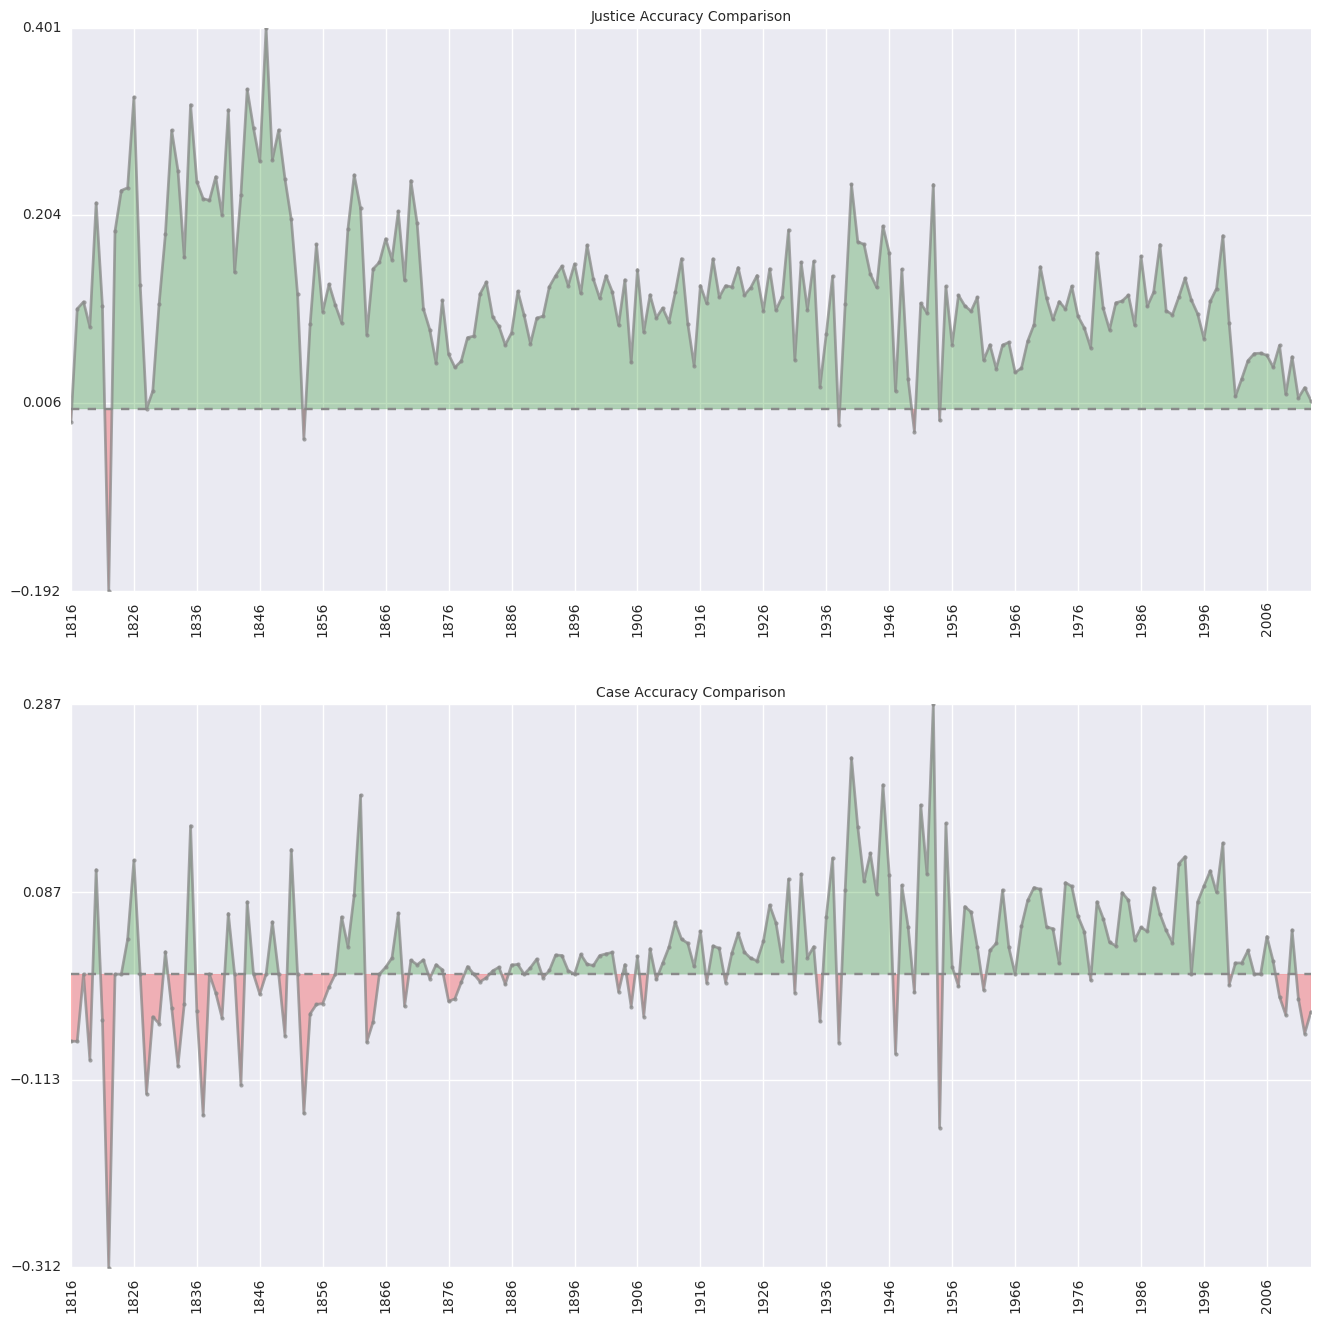

In [249]:
# Get last step weights
num_feature_rows = 2
num_feature_cols = 1
num_feature_total = num_feature_rows * num_feature_cols

# Get axis data
min_term = annual_ts_melt["term"].min()
max_term = annual_ts_melt["term"].max()

# Setup grid
#f = plt.figure(figsize=(16, 16))
f, ax = plt.subplots(num_feature_rows, num_feature_cols, figsize=(16,16))

# Handle justice accuracy
ax_id = 0
column_name = "Justice Accuracy Comparison"

# Setup title and data
ax[ax_id].set_title("{0}".format(column_name), fontsize=10)
ts_data = annual_ts.loc[:, "rf_correct"] - annual_ts.loc[:, "dummy_correct"]
min_val = ts_data.min()
max_val = ts_data.max()

# Plot fill and marker
ax[ax_id].axhline(0.0, linestyle='--', color='#898989') # horizontal lines
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data >= 0), alpha=0.25, color="green", interpolate=True)
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data < 0), alpha=0.25, color="red", interpolate=True)
ax[ax_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)

# Setup axes
_ = ax[ax_id].set_xlim(min_term, max_term)
_ = ax[ax_id].set_xticks(numpy.arange(min_term, max_term, 10))
_ = ax[ax_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
_ = ax[ax_id].set_ylim(min_val, max_val)
_ = ax[ax_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Handle justice accuracy
ax_id = 1
column_name = "Case Accuracy Comparison"

# Setup title and data
ax[ax_id].set_title("{0}".format(column_name), fontsize=10)
ts_data = annual_ts.loc[:, "rf_correct_case"] - annual_ts.loc[:, "dummy_correct_case"]
min_val = ts_data.min()
max_val = ts_data.max()

# Plot fill and marker
ax[ax_id].axhline(0.0, linestyle='--', color='#898989') # horizontal lines
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data >= 0), alpha=0.25, color="green", interpolate=True)
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data < 0), alpha=0.25, color="red", interpolate=True)
ax[ax_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)

# Setup axes
_ = ax[ax_id].set_xlim(min_term, max_term)
_ = ax[ax_id].set_xticks(numpy.arange(min_term, max_term, 10))
_ = ax[ax_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
_ = ax[ax_id].set_ylim(min_val, max_val)
_ = ax[ax_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_accuracy_comparison_trailing_cv_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_comparison_trailing_cv_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_comparison_trailing_cv_{0}.svg".format(file_timestamp))

## Tree Visualizations

/usr/local/lib/python3.5/dist-packages/sklearn/tree/export.py:386: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


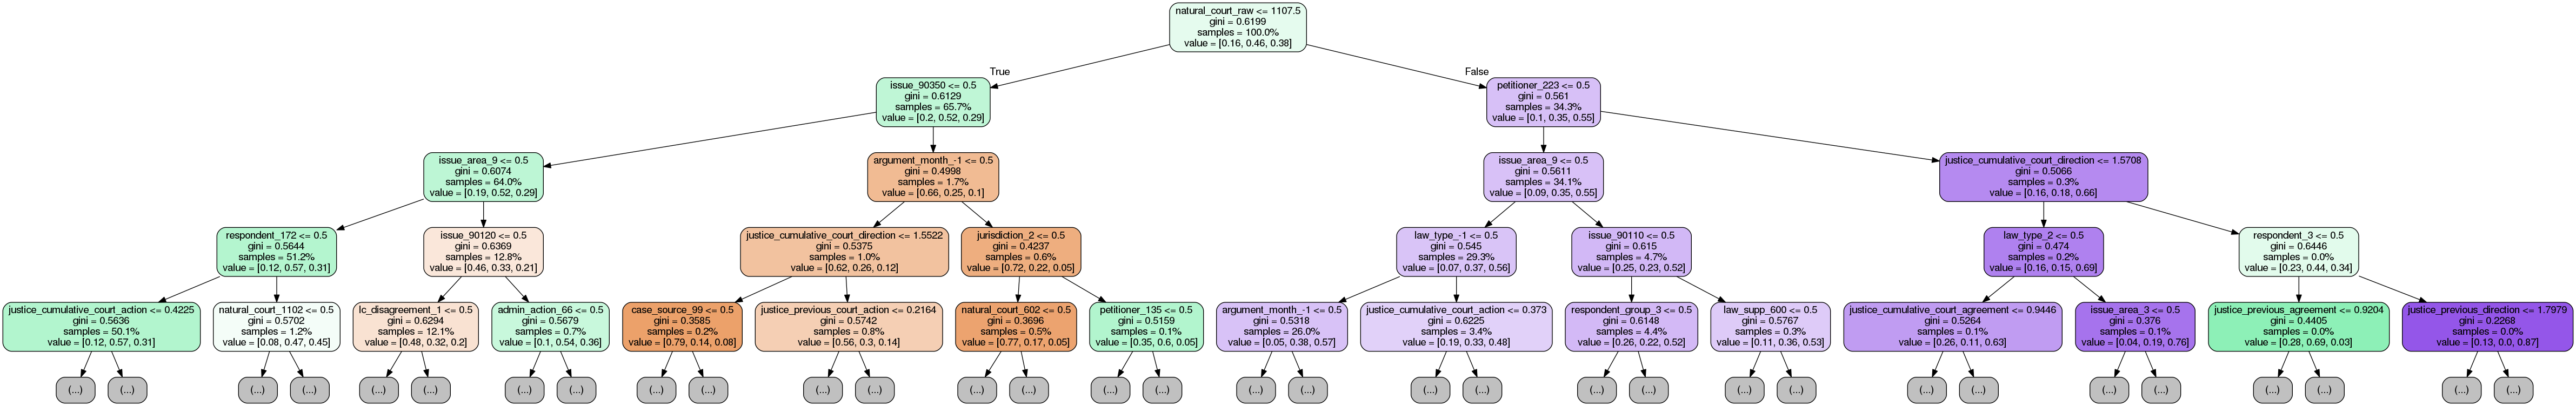

In [250]:
# Imports
import os
import pandas
from IPython.display import Image

# Visualize tree
sklearn.tree.export_graphviz(m.best_estimator_.steps[-1][-1].estimators_[0], max_depth=4, feature_names=feature_df.columns, filled=True, proportion=True, rounded=True)
os.system('dot -Tpng tree.dot -O')
Image(filename='tree.dot.png')

/usr/local/lib/python3.5/dist-packages/sklearn/tree/export.py:386: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


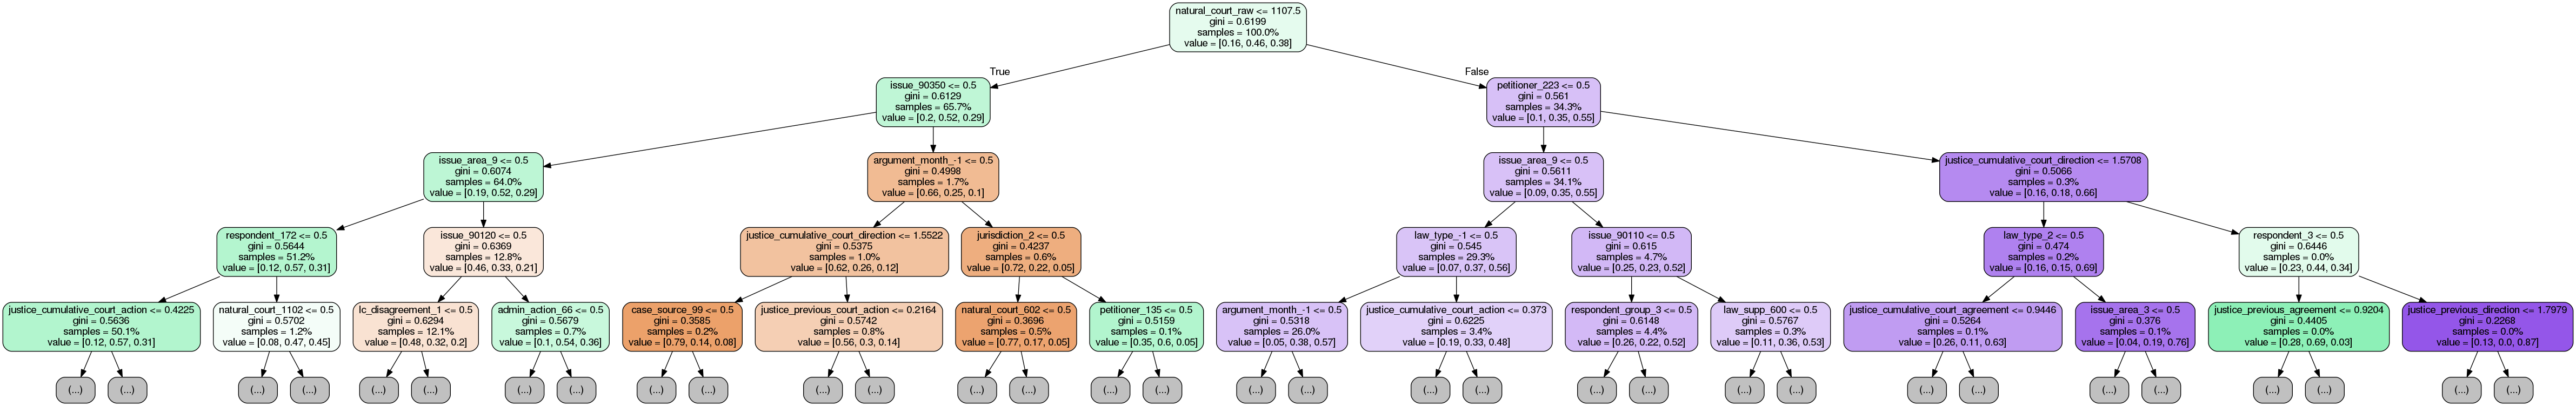

In [251]:
# Imports
import os
import pandas
from IPython.display import Image

# Visualize tree
sklearn.tree.export_graphviz(m.best_estimator_.steps[-1][-1].estimators_[1], max_depth=4, feature_names=feature_df.columns, filled=True, proportion=True, rounded=True)
os.system('dot -Tpng tree.dot -O')
Image(filename='tree.dot.png')

/usr/local/lib/python3.5/dist-packages/sklearn/tree/export.py:386: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


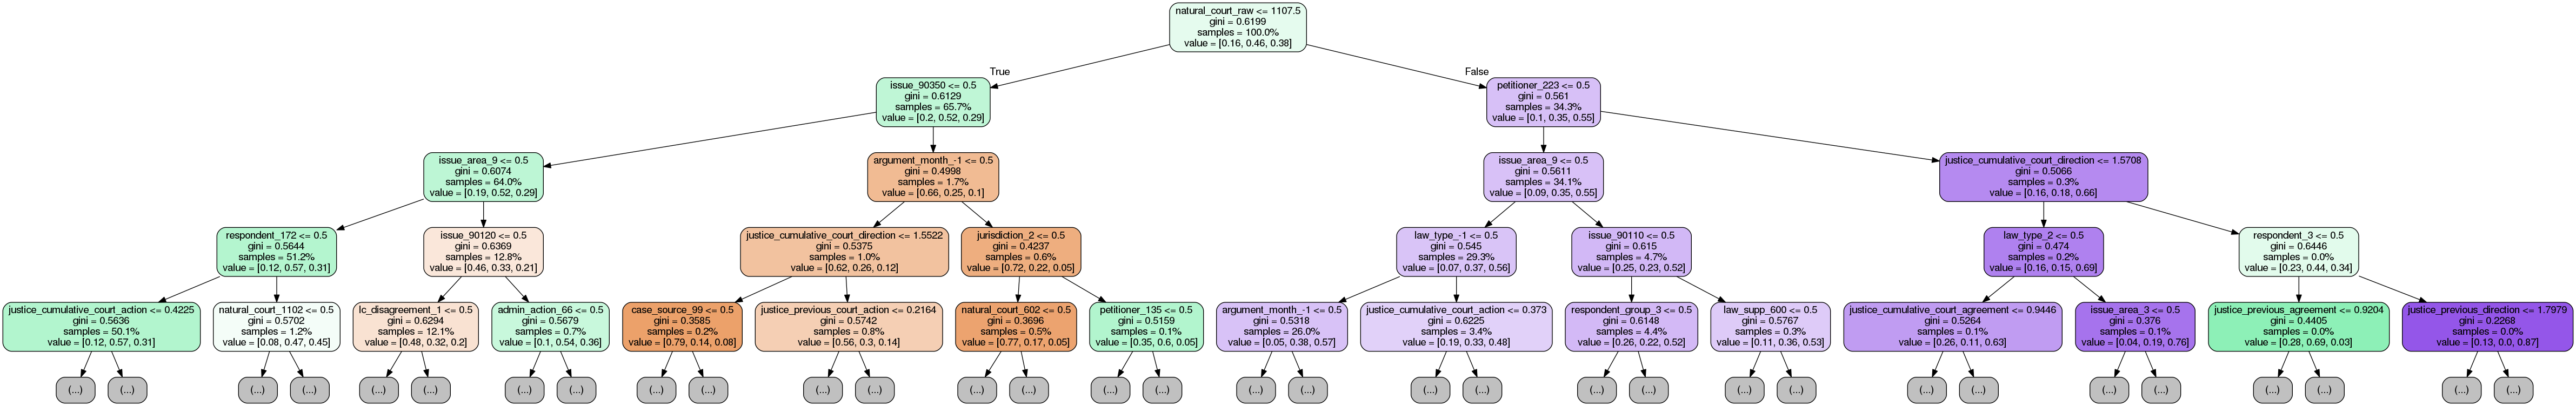

In [252]:
# Imports
import os
import pandas
from IPython.display import Image

# Visualize tree
sklearn.tree.export_graphviz(m.best_estimator_.steps[-1][-1].estimators_[2], max_depth=4, feature_names=feature_df.columns, filled=True, proportion=True, rounded=True)
os.system('dot -Tpng tree.dot -O')
Image(filename='tree.dot.png')